# Main notebook for collecting everything from "gennembrudsfiler" in a better (and useful) way...

In [2]:
%matplotlib widget
# Load packages and settings
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 50)
import seaborn as sns



import sys
sys.path.append("./../scripts")
import PandemiXFunctions as pf

import geopandas as gpd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams["image.cmap"] = "tab10"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
fs_label = 16
parameters = {
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.markersize': 10,
                'lines.linewidth': 3
             }
plt.rcParams.update(parameters)
from matplotlib import cm # Colormaps
import matplotlib.colors as colors
# cmap = plt.cm.get_cmap('Dark2',len(ageGroups))

import locale
import matplotlib.dates as mdates
# locale.setlocale(locale.LC_TIME,"Danish")
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
# ax1.spines['top'].set_visible(False) 

import os
# import csv
import math

# from datetime import date
import datetime


saveFigures = True
# saveFigures = False
print('saveFigures is set to: '+str(saveFigures))

print('Done loading packages')

saveFigures is set to: True
Done loading packages


In [3]:
# Define paths
rootdir_data = os.getcwd() +"/../DanskeData/" 

path_data = rootdir_data + "ssi_data/"
path_dash = rootdir_data + "ssi_dashboard/"
path_vacc = rootdir_data + "ssi_vacc/"

path_figs = os.getcwd() +"/../Figures/" 

In [4]:
# Cases for comparison
latestsubdir = list(os.walk(path_dash))[0][1][-1]
latestdir = path_dash + latestsubdir

dfReinfFile = pd.read_csv(latestdir+'/Regionalt_DB/24_reinfektioner_daglig_region.csv',encoding='latin1',delimiter = ';')
dfReinfFile['Prøvedato'] = pd.to_datetime(dfReinfFile['Prøvedato'])
# groupdf = df.groupby(['Prøvedato').sum()
# df_reinf = dfReinfFile[dfReinfFile['Type af tilfælde (reinfektion eller bekræftet tilfælde)'] == '1.Reinfektion'].groupby('Prøvedato').sum()
# df_inf = dfReinfFile[dfReinfFile['Type af tilfælde (reinfektion eller bekræftet tilfælde)'] != '1.Reinfektion'].groupby('Prøvedato').sum()
df_reinf = dfReinfFile[dfReinfFile['Type af tilfælde (reinfektion eller første infektion)'] == '1.Reinfektion'].groupby('Prøvedato').sum()
df_inf = dfReinfFile[dfReinfFile['Type af tilfælde (reinfektion eller første infektion)'] != '1.Reinfektion'].groupby('Prøvedato').sum()

# Each tuesday, data for the last 16 weeks were made available 
To minimize reporting delay, the most recent 16 weeks use the most recent file. To get the rest of the data, last row is used from each file.

For sanity, start with just population counts in table1

In [5]:
# Start by getting the most recent data

for k in range(0,7):
    dayToCheck = np.datetime64('today')-np.timedelta64(k,'D')
    thisWeekDay = (dayToCheck).astype(datetime.datetime).isoweekday()    
    if (thisWeekDay == 2):
        mostRecentTuesday = dayToCheck
        tuePath = 'SSI_data_'+str(dayToCheck)
        if (os.path.exists(path_data + tuePath) == False):
            print('No data for most recent tuesday... If after 14:00, download new data')
            tuePath = 'SSI_data_'+str(dayToCheck-np.timedelta64(7,'D')) 
print(f'Path to latest Tuesday was {tuePath}')

dirPath = path_data + tuePath + '/'

dfRecent = pd.read_csv(dirPath+'gennembrudsinfektioner_table1.csv',delimiter=';')


No data for most recent tuesday... If after 14:00, download new data
Path to latest Tuesday was SSI_data_2022-03-22


In [6]:
# Go through each tuesday, as long back as possible, and grab the last row

# Start by taking all data from the most recent file
df_main = dfRecent.copy()

# allRows = [] 
colNamesToChange = {
'antal_personer_alle_Fuld vaccineeffekt': 'antal_personer_alle_Fuld effekt efter primært forløb',
'antal_personer_Fuld vaccineeffekt': 'antal_personer_Fuld effekt efter primært forløb',
'antal_cases_Fuld vaccineeffekt': 'antal_cases_Fuld effekt efter primært forløb',
'antal_repositive_Fuld vaccineeffekt': 'antal_repositive_Fuld effekt efter primært forløb',
'antal_indlagte_Fuld vaccineeffekt': 'antal_indlagte_Fuld effekt efter primært forløb',
'antal_tests_Fuld vaccineeffekt': 'antal_tests_Fuld effekt efter primært forløb',
'antal_tests_total_Fuld vaccineeffekt': 'antal_tests_total_Fuld effekt efter primært forløb',
}

maxWeeksBack = 50
for k in range(1,maxWeeksBack):
    curTue = mostRecentTuesday - np.timedelta64(7*k,'D')
    curTuePath = 'SSI_data_'+str(curTue)

    dirPath = path_data + curTuePath + '/'
    filePath = dirPath+'gennembrudsinfektioner_table1.csv'
    if os.path.exists(filePath):
        df1 = pd.read_csv(filePath,delimiter=';')
    else:
        continue

    # Check length of "ugenummer" columns
    if (len(df1.iloc[0,0]) == 11):
        # If length is 11, the year was included

        # Figure out order, to be able to get oldest
        weekDTs = [np.datetime64(datetime.datetime.strptime(d[-4:] + '-W'+d[4:6]+'-1', "%Y-W%W-%w")) for d in df1.Ugenummer]
        curOrder = np.argsort(weekDTs)
        df1 = df1.rename(columns=colNamesToChange) 

        oldestIndex = np.where(curOrder == 0)[0][0]
        # print(df1.iloc[oldestIndex,0])
        # display(df1.iloc[oldestIndex,1])

        # allRows.append(df1.iloc[oldestIndex,:])
        # df_main = df_main.append(df1.iloc[oldestIndex,:])
        df_main = pd.concat([df_main,df1.iloc[oldestIndex:oldestIndex+1,:]])
    else:
        # display(df1)

        # Rename weeknumber to have year
        df1.iloc[-1,0] = df1.iloc[-1,0] + '-2021'
        # And rename "Fuld Effekt" columns
        df1 = df1.rename(columns=colNamesToChange) 



        # print(df1.iloc[-1,0])
        # allRows.append(df1.iloc[-1,:])
        # df_main = df_main.append(df1.iloc[-1,:])
        df_main = pd.concat([df_main,df1.iloc[-1:,:]])


In [7]:
# Reset indices, correct the order and fill NaN
df_main = df_main.fillna(0)
df_main = df_main[::-1]
df_main = df_main.reset_index(drop=True)

In [8]:
df_main

Ugenummer  antal_personer_alle_Ingen vaccination  \
0   Uge 21-2021                                3992139   
1   Uge 22-2021                                3734883   
2   Uge 23-2021                                3476258   
3   Uge 24-2021                                3143823   
4   Uge 25-2021                                2840153   
5   Uge 26-2021                                2618016   
6   Uge 27-2021                                2452684   
7   Uge 28-2021                                2177158   
8   Uge 29-2021                                1951031   
9   Uge 30-2021                                1776148   
10  Uge 31-2021                                1661241   
11  Uge 32-2021                                1587965   
12  Uge 33-2021                                1541838   
13  Uge 34-2021                                1504399   
14  Uge 35-2021                                1474440   
15  Uge 36-2021                                1454914   
16  Uge 37-2021                                1441432   
17  Uge 38-2021                                1431736   
18  Uge 39-2021                                1424055   
19  Uge 40-2021                                1418113   
20  Uge 41-2021                                1413212   
21  Uge 42-2021                                1409358   
22  Uge 43-2021                                1404922   
23  Uge 44-2021                                1397794   
24  Uge 45-2021                                1388608   
25  Uge 46-2021                                1363556   
26  Uge 47-2021                                1341852   
27  Uge 48-2021                                1323831   
28  Uge 48-2021                                1323831   
29  Uge 49-2021                                1283901   
30  Uge 50-2021                                1212832   
31  Uge 51-2021                                1130426   
32  Uge 52-2021                                1098880   
33  Uge 01-2022                                1076601   
34  Uge 02-2022                                1057845   
35  Uge 03-2022                                1047793   
36  Uge 04-2022                                1042232   
37  Uge 05-2022                                1039952   
38  Uge 06-2022                                1039074   
39  Uge 07-2022                                1039023   
40  Uge 08-2022                                1039154   
41  Uge 09-2022                                1039375   
42  Uge 10-2022                                1039656   
43  Uge 11-2022                                1039813   

    antal_personer_alle_Første vaccination  \
0                                   688900   
1                                   880120   
2                                  1023968   
3                                  1225848   
4                                  1380484   
5                                  1403070   
6                                  1310565   
7                                  1348997   
8                                  1270038   
9                                  1128721   
10                                 1000585   
11                                  803692   
12                                  512967   
13                                  340885   
14                                  233054   
15                                  168666   
16                                  133837   
17                                  110247   
18                                   91880   
19                                   80888   
20                                   74645   
21                                   69796   
22                                   67992   
23                                   68316   
24                                   72708   
25                                  109433   
26                                  125820   
27                                  131371   
28                                  131371   
29             

In [9]:
# allRows[-7]
df_main

allDTs = []
for k in range(len(df_main)):
    curWN = df_main.iloc[k,0]
    if len(curWN)==11: 
        curDT = np.datetime64(datetime.datetime.strptime(curWN[-4:] + '-W'+curWN[4:6]+'-1', "%Y-W%W-%w"))
    else:
        curDT = np.datetime64(datetime.datetime.strptime('2021-W'+curWN[4:6]+'-1', "%Y-W%W-%w"))
    allDTs.append(curDT)



In [10]:
sNone = 'Ingen vaccination'
sOnce = 'Første vaccination'
sBoth = 'Anden vaccination'
sFull = 'Fuld effekt efter primært forløb'
sReva = 'Fuld effekt efter revaccination'

allS = [sNone,sOnce,sBoth,sFull,sReva] 

In [11]:
# curData = 'antal_personer_alle_'
# curData = 'antal_personer_'

# unva = df_main[curData+sNone]
# once = df_main[curData+sOnce]
# both = df_main[curData+sBoth]
# full = df_main[curData+sFull]
# reva = df_main[curData+sReva]

# # once = df_main.iloc[:,2]
# # both = df_main.iloc[:,3]
# # full_pri = df_main.iloc[:,4].fillna(0)
# # full_old = df_main.iloc[:,-4].fillna(0)
# # full = full_pri + full_old
# # reva = df_main.iloc[:,5].fillna(0)

# fig,ax1 = plt.subplots()

# ax1.plot(allDTs,unva)
# ax1.plot(allDTs,once)
# ax1.plot(allDTs,both)
# ax1.plot(allDTs,full)
# ax1.plot(allDTs,reva)

In [12]:

# unva = df_main.iloc[:,1]
# once = df_main.iloc[:,2]
# both = df_main.iloc[:,3]
# full_pri = df_main.iloc[:,4].fillna(0)
# full_old = df_main.iloc[:,-4].fillna(0)
# full = full_pri + full_old
# reva = df_main.iloc[:,5].fillna(0)


curData = 'antal_personer_alle_'
# curData = 'antal_personer_'

unva = df_main[curData+sNone]
once = df_main[curData+sOnce]
both = df_main[curData+sBoth]
full = df_main[curData+sFull]
reva = df_main[curData+sReva]


popSize = unva+once+both

# fig,ax1 = plt.subplots()

# ax1.stackplot(allDTs,
#                 reva,
#                 full,
#                 both-full-reva,
#                 once,
#                 unva,
#                 colors=['xkcd:dark green','xkcd:green','xkcd:cyan','xkcd:blue','m'],
#                 labels=['Full effect after booster','Full effect after two doses','Two doses','One dose','Unvaccinated']
#         )
        

# ax1.legend(loc='upper left')

# ax1.set_xlim([np.min(allDTs),np.max(allDTs)])

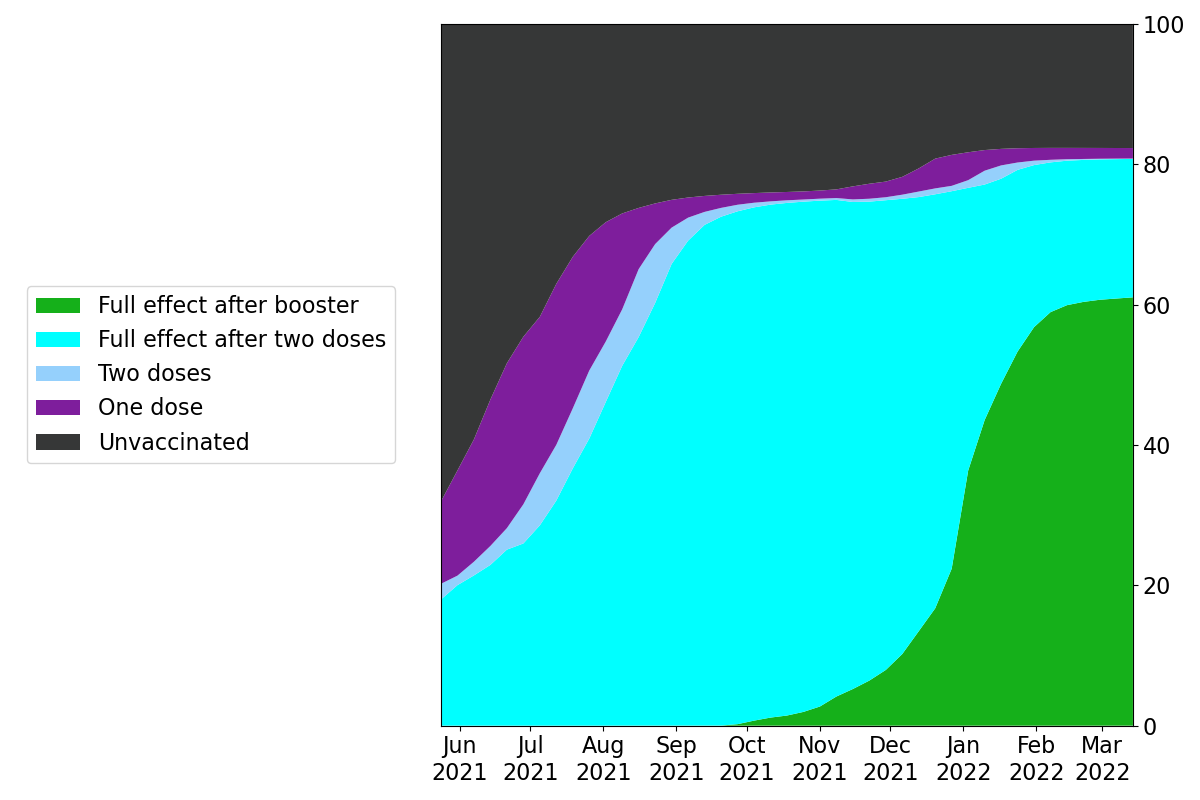

In [13]:

fig,ax1 = plt.subplots()
ax1.stackplot(allDTs,
                100*(reva)/popSize,
                100*(full)/popSize,
                100*(both-full-reva)/popSize,
                100*(once)/popSize,
                100*(unva)/popSize,
                colors=['xkcd:green','xkcd:cyan','xkcd:light blue','xkcd:purple','xkcd:dark grey'],
                labels=['Full effect after booster','Full effect after two doses','Two doses','One dose','Unvaccinated']
        )
        
# ax1.set_ylim([0,100])
# # ax1.legend(loc='upper left')
# ax1.legend(bbox_to_anchor=(-0.05,0.5),loc='center left')

# ax1.set_xlim([np.min(allDTs),np.max(allDTs)])
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))



# fig.tight_layout()
ax1.set_ylim([0,100])
# ax1.legend(loc='upper left')
# ax1.legend(bbox_to_anchor=(1.05,0.5),loc='center left')
ax1.legend(bbox_to_anchor=(-0.05,0.5),loc='center right')

ax1.set_xlim([np.min(allDTs),np.max(allDTs)])

ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()


ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

fig.tight_layout()

fig.savefig(path_figs+'Immunity/TotalPopulationImmunity_VaccineOnly')


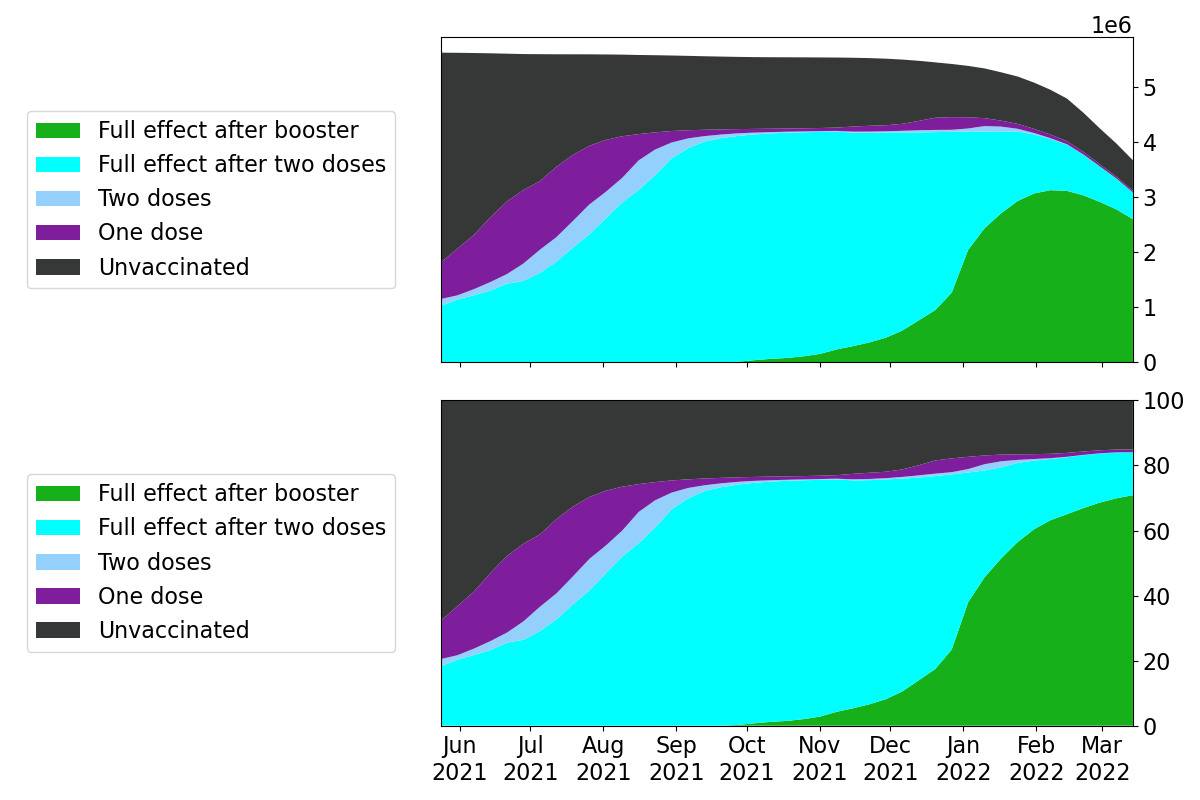

In [14]:

# unva = df_main.iloc[:,6]
# once = df_main.iloc[:,7]
# both = df_main.iloc[:,8]
# full_pri = df_main.iloc[:,4].fillna(0)
# full_old = df_main.iloc[:,-4].fillna(0)
# full = full_pri + full_old
# reva = df_main.iloc[:,9].fillna(0)



# curData = 'antal_personer_alle_'
curData = 'antal_personer_'

unva = df_main[curData+sNone]
once = df_main[curData+sOnce]
both = df_main[curData+sBoth]
full = df_main[curData+sFull]
reva = df_main[curData+sReva]

popSize = unva+once+both

fig,(ax1,ax2) = plt.subplots(2,1,sharex=True)


ax1.stackplot(allDTs,
                reva,
                full,
                both-full-reva,
                once,
                unva,
                colors=['xkcd:green','xkcd:cyan','xkcd:light blue','xkcd:purple','xkcd:dark grey'],
                labels=['Full effect after booster','Full effect after two doses','Two doses','One dose','Unvaccinated']
        )
        
        
ax2.stackplot(allDTs,
                100*reva/popSize,
                100*full/popSize,
                100*(both-full-reva)/popSize,
                100*once/popSize,
                100*unva/popSize,
                colors=['xkcd:green','xkcd:cyan','xkcd:light blue','xkcd:purple','xkcd:dark grey'],
                labels=['Full effect after booster','Full effect after two doses','Two doses','One dose','Unvaccinated']
        )
        
ax1.legend(bbox_to_anchor=(-0.05,0.5),loc='center right')
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax2.set_ylim([0,100])
ax2.legend(bbox_to_anchor=(-0.05,0.5),loc='center right')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()


ax1.set_xlim([np.min(allDTs),np.max(allDTs)])
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

fig.tight_layout()

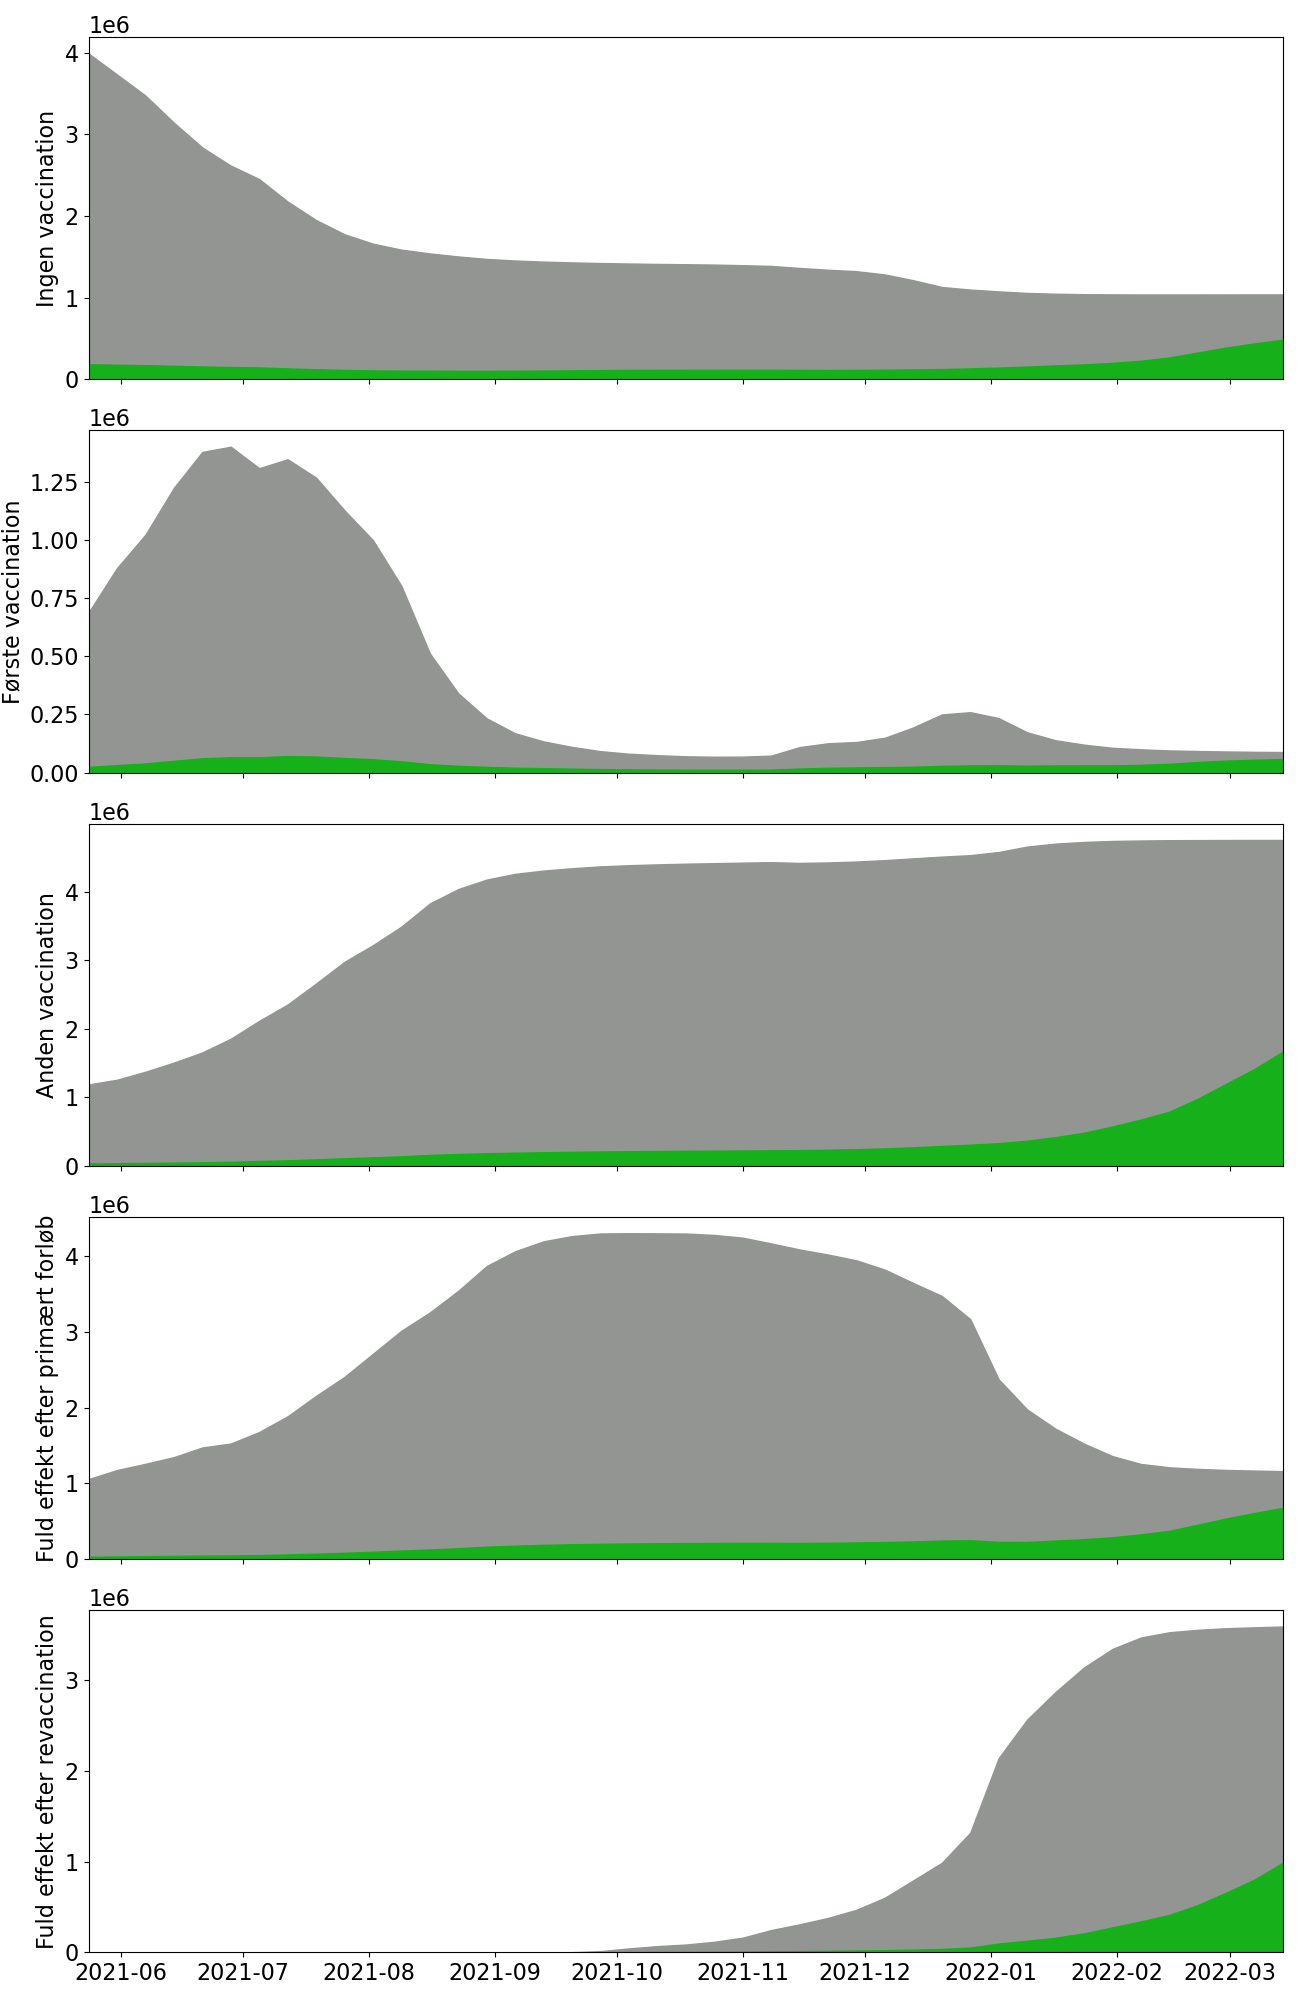

In [15]:
# Make comparative plots of population sizes
fig,allAx = plt.subplots(5,1,figsize=(13,20),sharex=True)

# ax = allAx[0]

# curStatus = sNone 

for i,curStatus in enumerate(allS):
    ax = allAx[i]
    curAll = df_main['antal_personer_alle_'+curStatus]
    curPer = df_main['antal_personer_'+curStatus]
    curDif = curAll-curPer 
    ax.fill_between(allDTs,curAll,color='xkcd:grey')
    ax.fill_between(allDTs,curDif,color='xkcd:green')
    ax.set_ylabel(curStatus)
    ax.set_ylim(bottom=0)

ax.set_xlim(allDTs[0],allDTs[-1])
fig.tight_layout()

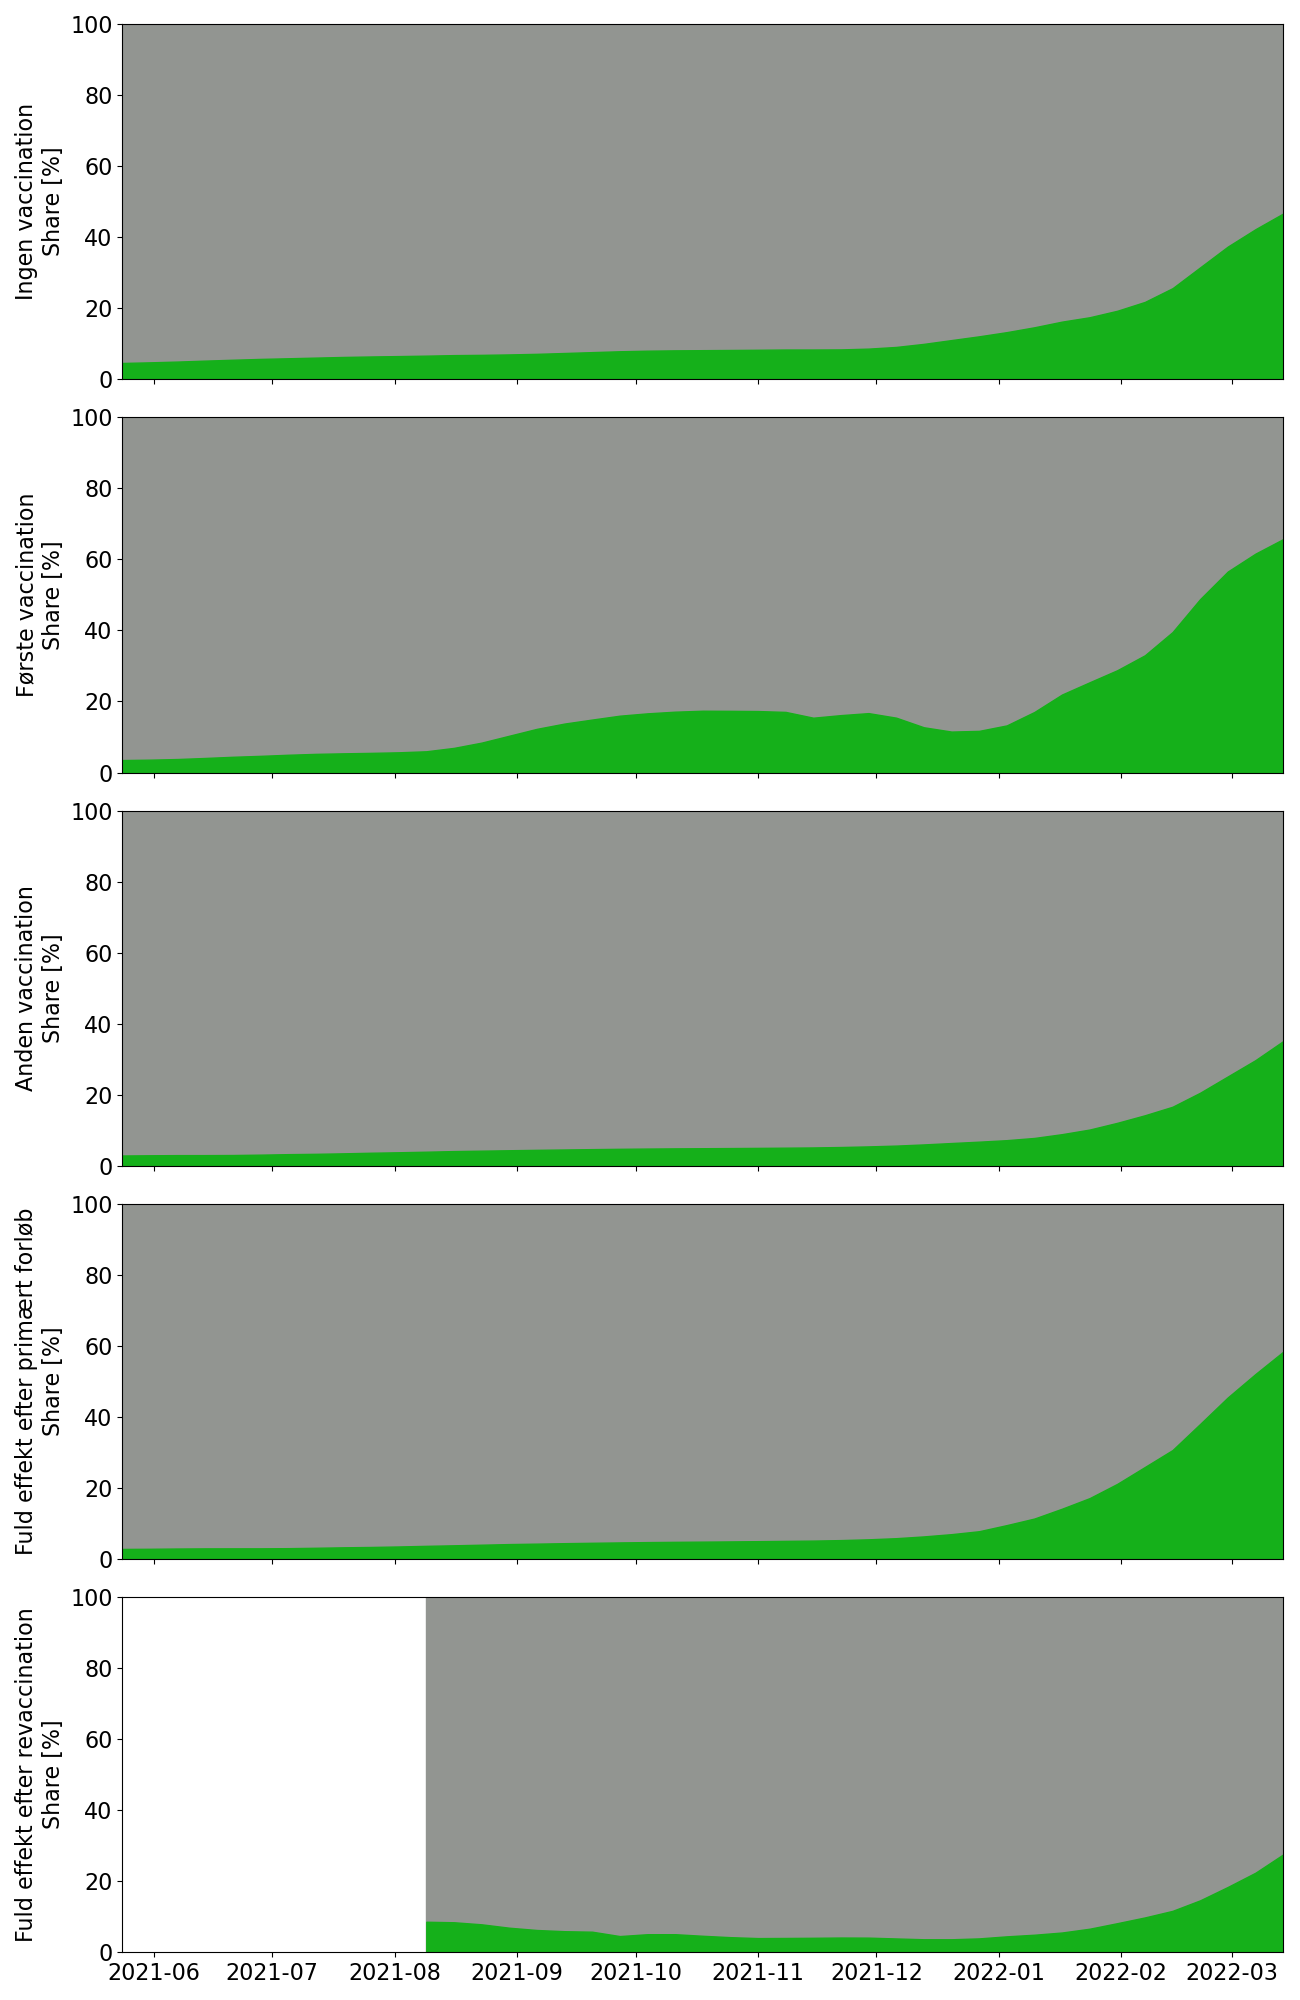

In [16]:
# As above, but as a fraction
fig,allAx = plt.subplots(5,1,figsize=(13,20),sharex=True)


for i,curStatus in enumerate(allS):
    ax = allAx[i]
    curAll = df_main['antal_personer_alle_'+curStatus]
    curPer = df_main['antal_personer_'+curStatus]
    curDif = curAll-curPer 
    ax.fill_between(allDTs,100*curAll/curAll,color='xkcd:grey')
    ax.fill_between(allDTs,100*curDif/curAll,color='xkcd:green')
    ax.set_ylabel(curStatus+'\nShare [%]')
    ax.set_ylim(bottom=0,top=100)

ax.set_xlim(allDTs[0],allDTs[-1])
fig.tight_layout()

# Figures as if data was up-to-date

In [17]:
curData = 'antal_personer_alle_'


unva = df_main[curData+sNone]
once = df_main[curData+sOnce]
both = df_main[curData+sBoth]
full = df_main[curData+sFull]
reva = df_main[curData+sReva]

popSize = unva+once+both

curData = 'antal_personer_'

unva_neg = df_main[curData+sNone]
once_neg = df_main[curData+sOnce]
both_neg = df_main[curData+sBoth]
full_neg = df_main[curData+sFull]
reva_neg = df_main[curData+sReva]


unva_pos = unva - unva_neg
once_pos = once - once_neg
both_pos = both - both_neg
full_pos = full - full_neg
reva_pos = reva - reva_neg

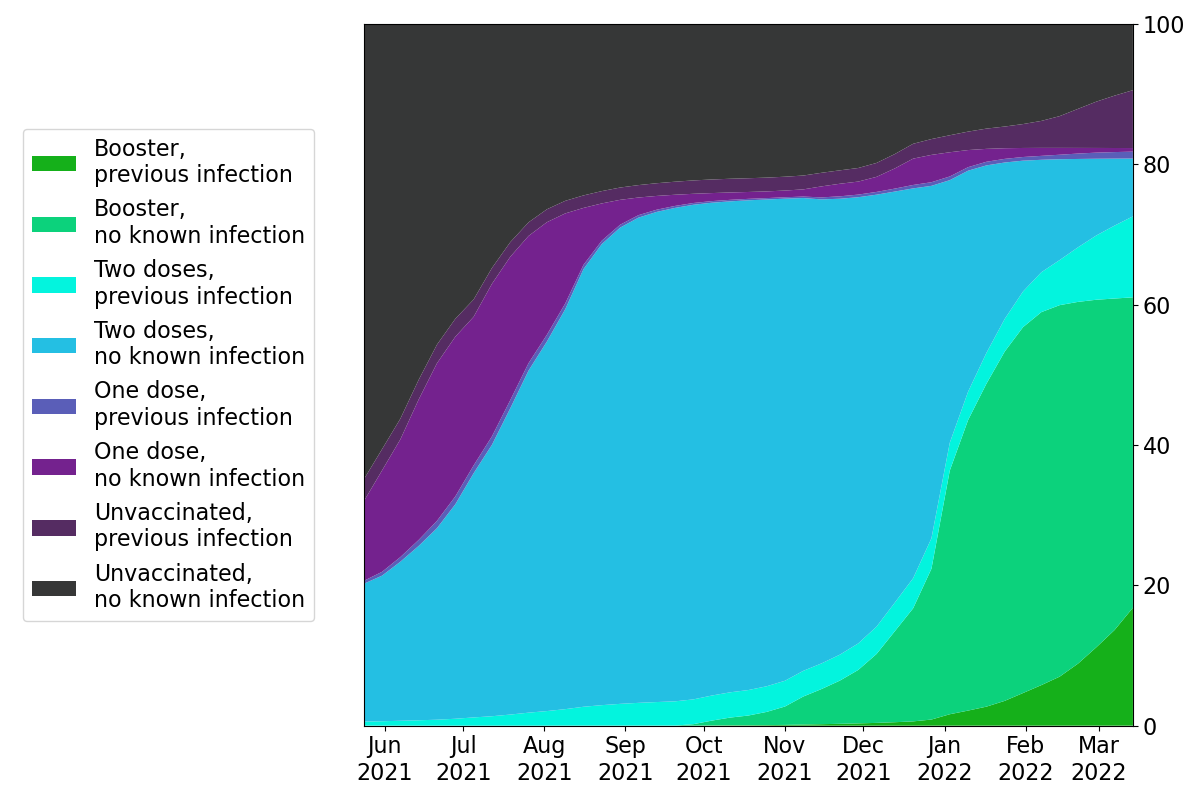

In [18]:



cmap = pf.getColormapFromList(['xkcd:green','xkcd:cyan','xkcd:purple','xkcd:dark grey'],8)
allLabels= ['Booster,\nprevious infection','Booster,\nno known infection','Two doses,\nprevious infection','Two doses,\nno known infection','One dose,\nprevious infection','One dose,\nno known infection','Unvaccinated,\nprevious infection','Unvaccinated,\nno known infection']
fig,ax1 = plt.subplots()
ax1.stackplot(allDTs,
                100*(reva_pos)/popSize,
                100*(reva_neg)/popSize,
                # 100*(full_pos)/popSize,
                # 100*(full_neg)/popSize,
                # 100*(both_pos-full_pos-reva_pos)/popSize,
                # 100*(both_neg-full_neg-reva_neg)/popSize,
                100*(both_pos-reva_pos)/popSize,
                100*(both_neg-reva_neg)/popSize,
                100*(once_pos)/popSize,
                100*(once_neg)/popSize,
                100*(unva_pos)/popSize,
                100*(unva_neg)/popSize,
                # colors=['xkcd:dark green','xkcd:green','xkcd:cyan','xkcd:blue','m'],
                # labels=['Full effect after booster','Full effect after two doses','Two doses','One dose','Unvaccinated']
                colors = [cmap(k) for k in range(0,8)],
                labels= allLabels 
        )
        
ax1.set_ylim([0,100])
# ax1.legend(loc='upper left')
# ax1.legend(bbox_to_anchor=(1.05,0.5),loc='center left')
ax1.legend(bbox_to_anchor=(-0.05,0.5),loc='center right')

ax1.set_xlim([np.min(allDTs),np.max(allDTs)])

ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()


ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

fig.tight_layout()

fig.savefig(path_figs+'Immunity/TotalPopulationImmunity')

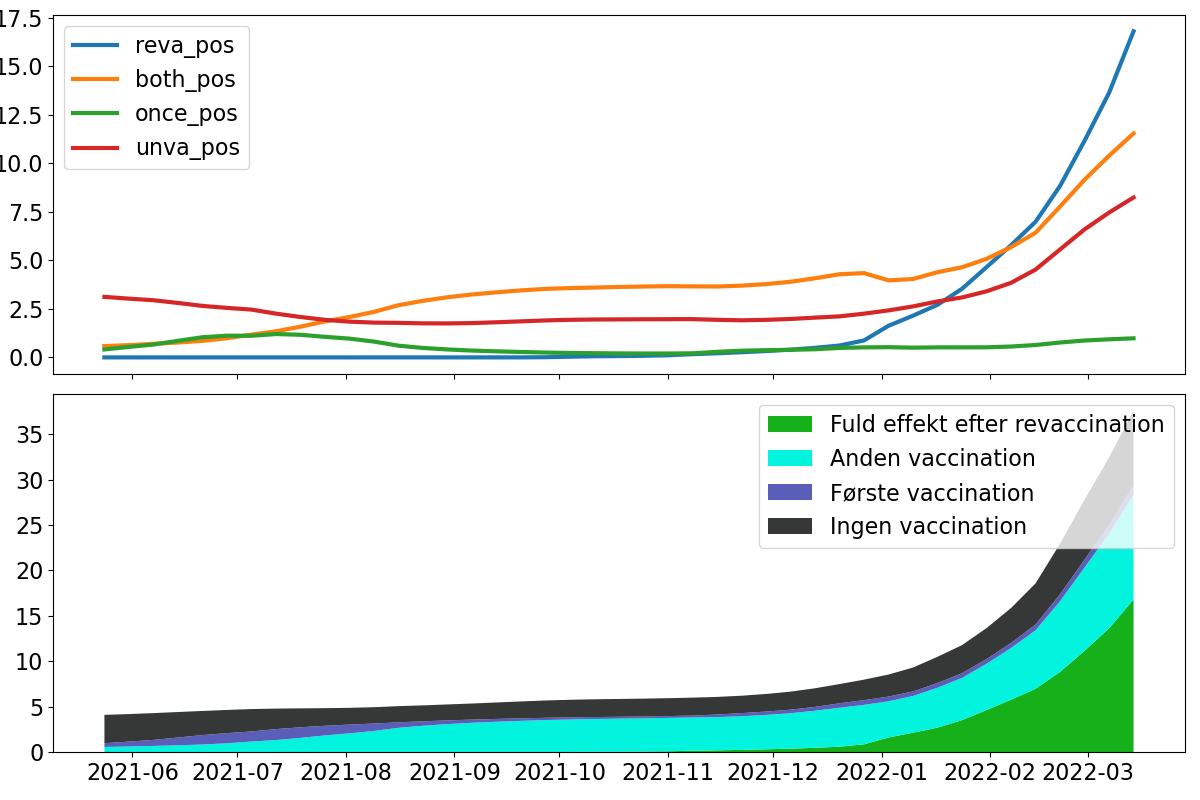

In [19]:
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True)
ax1.plot(allDTs,100*(reva_pos)/popSize,label='reva_pos')
ax1.plot(allDTs,100*(both_pos-reva_pos)/popSize,label='both_pos')
ax1.plot(allDTs,100*(once_pos)/popSize,label='once_pos')
ax1.plot(allDTs,100*(unva_pos)/popSize,label='unva_pos')
ax1.legend()

ax2.stackplot(allDTs,
            100*reva_pos/popSize,
            100*(both_pos-reva_pos)/popSize,
            100*once_pos/popSize,
            100*unva_pos/popSize,    
            colors=[cmap(0),cmap(2),cmap(4),cmap(8)],
            labels=[sReva,sBoth,sOnce,sNone]        
    )
ax2.legend()

fig.tight_layout()

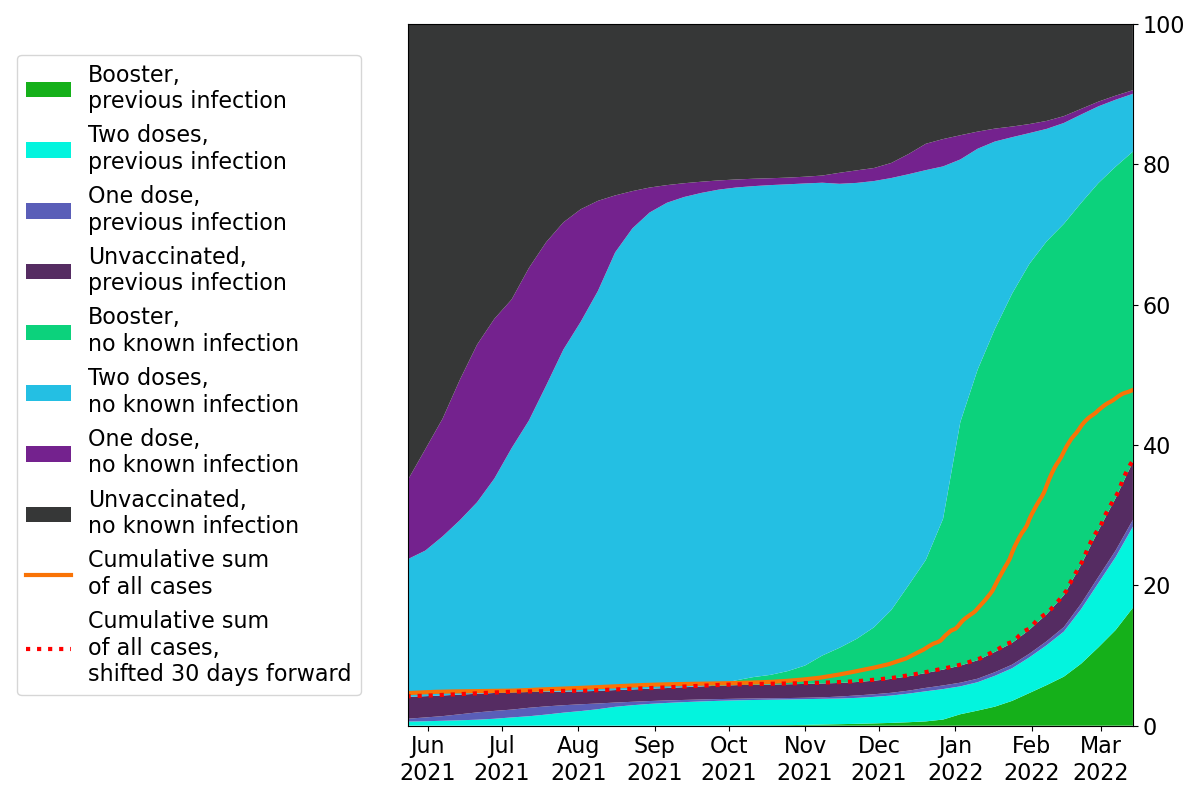

In [20]:
fig,ax1 = plt.subplots()
ax1.stackplot(allDTs,
                100*(reva_pos)/popSize,
                100*(both_pos-reva_pos)/popSize,
                100*(once_pos)/popSize,
                100*(unva_pos)/popSize,
                100*(reva_neg)/popSize,
                100*(both_neg-reva_neg)/popSize,
                100*(once_neg)/popSize,
                100*(unva_neg)/popSize,
                colors = [cmap(0),cmap(2),cmap(4),cmap(6),cmap(1),cmap(3),cmap(5),cmap(7)],
                labels= [allLabels[0],allLabels[2],allLabels[4],allLabels[6],allLabels[1],allLabels[3],allLabels[5],allLabels[7]],
                # labels=['Booster,\nprevious infection','Booster,\nno known infection','Two doses,\nprevious infection','Two doses,\nno known infection','One dose,\nprevious infection','One dose,\nno known infection','Unvaccinated,\nprevious infection','Unvaccinated,\nno known infection']
        )
        
ax1.set_ylim([0,100])
# ax1.legend(loc='upper left')
# ax1.legend(bbox_to_anchor=(1.05,0.5),loc='center left')
ax1.legend(bbox_to_anchor=(-0.05,0.5),loc='center right')

ax1.set_xlim([np.min(allDTs),np.max(allDTs)])

ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()


ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))



fig.tight_layout()

fig.savefig(path_figs+'Immunity/TotalPopulationImmunity_PosNeg')


dkPop = popSize.values[-1]
ax1.plot(df_inf.index,100*np.cumsum(df_inf.infected)/dkPop,'xkcd:orange',label='Cumulative sum\nof all cases')
ax1.plot(df_inf.index+np.timedelta64(30,'D'),100*np.cumsum(df_inf.infected)/dkPop,'r:',label='Cumulative sum\nof all cases,\nshifted 30 days forward')
ax1.legend(bbox_to_anchor=(-0.05,0.5),loc='center right')

fig.tight_layout()

fig.savefig(path_figs+'Immunity/TotalPopulationImmunity_PosNeg_Compare')


# Try to compare cases with national numbers

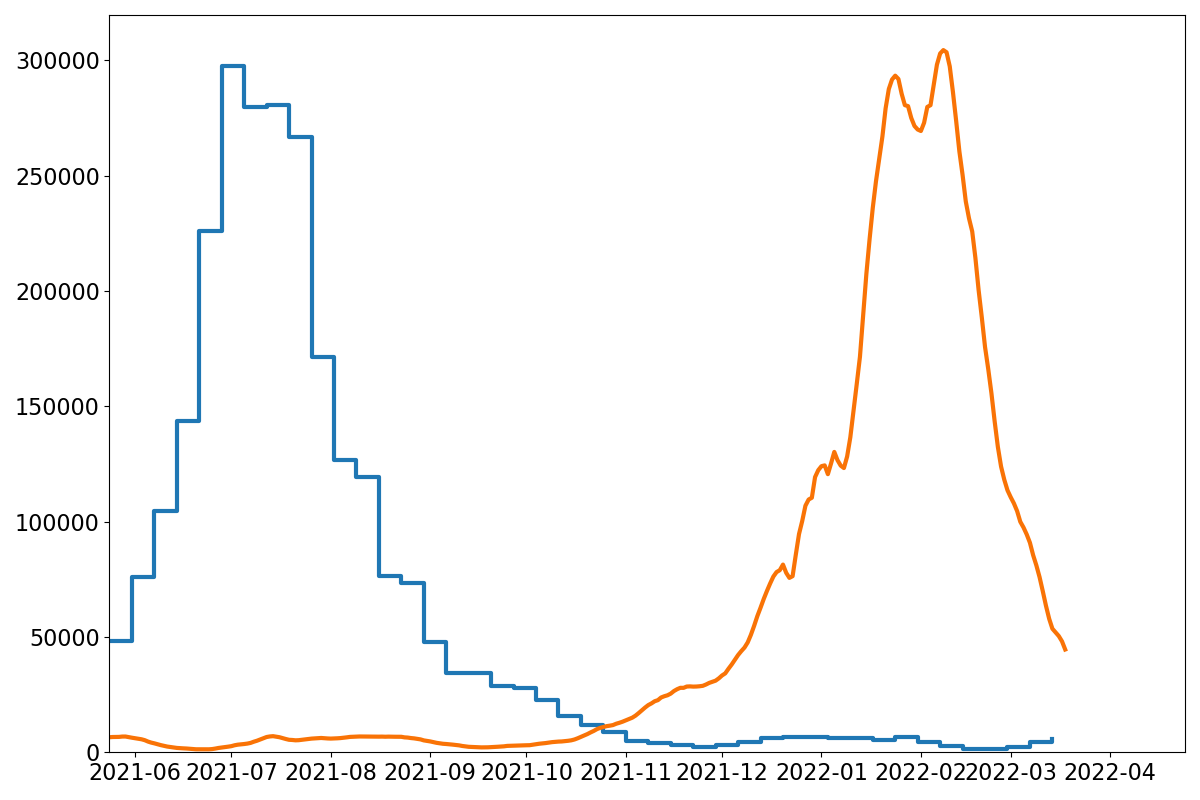

In [140]:
firstCaseIndex = np.where(df_main.columns == 'antal_cases_Ingen vaccination')[0][0]

totCase = df_main.iloc[:,firstCaseIndex:firstCaseIndex+3].sum(axis=1)
# totCase

fig,ax1 = plt.subplots()
ax1.step(allDTs,totCase,where='post')
# ax1.plot(allDTs,totCase,'*:')
# ax1.plot(df_inf.index,df_inf.infected,'xkcd:orange',label='Fra regional_DB filer')
ax1.plot(pf.rnTime(df_inf.index),pf.rnMean(df_inf.infected)*7,'xkcd:orange',label='Fra regional_DB filer')

ax1.set_xlim(left=allDTs[0])
ax1.set_ylim(bottom=0)

fig.tight_layout()

In [22]:
# prevPos = (totAlle - totPers).values[:-4]


# prevCase = np.cumsum(totCase) + (totAlle[0]-totPers[0])
# curPos = prevCase[4:] - prevCase[:-4]

# curPos[-4:]

# print(np.concatenate([(curAlle-curPers)[4:],prevNone[-4:]]))
# print(np.concatenate([(curAlle-curPers)[5:],prevNone[-5:]]))


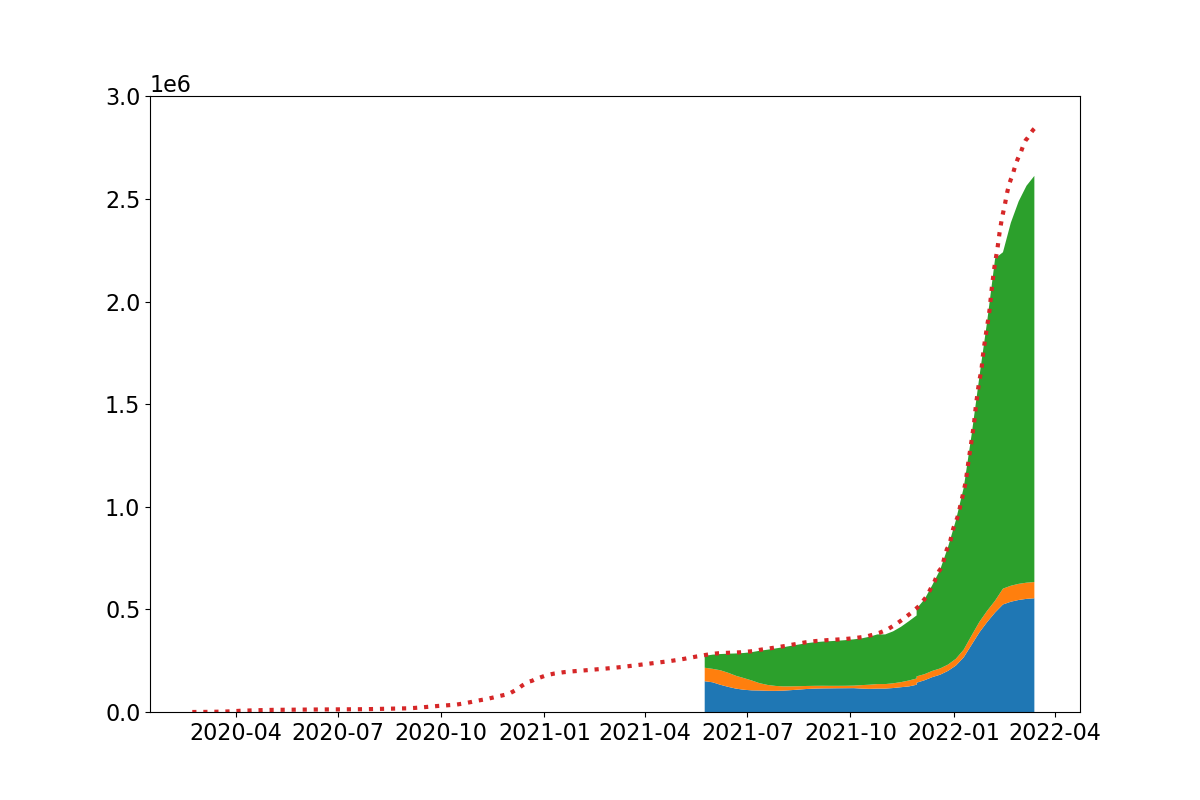

In [23]:
# curdf = df_main.iloc[-20:,:]
# curDates = allDTs[-20:]
curdf = df_main.copy()
curDates = allDTs.copy()

curS = sNone
curAlle = curdf.loc[:,'antal_personer_alle_'+curS].values
curPers = curdf.loc[:,'antal_personer_'+curS].values
curDif = curAlle - curPers
# prevNone = np.cumsum(curdf.loc[:,'antal_cases_'+curS]) + curDif[0]
prevNone = np.cumsum(curdf.loc[:,'antal_cases_'+curS]) 
toUseNone = np.concatenate([(curAlle-curPers)[5:],prevNone[-5:]])


curS = sOnce
curAlle = curdf.loc[:,'antal_personer_alle_'+curS].values
curPers = curdf.loc[:,'antal_personer_'+curS].values
curDif = curAlle - curPers
prevOnce = np.cumsum(curdf.loc[:,'antal_cases_'+curS]) 
toUseOnce = np.concatenate([(curAlle-curPers)[5:],prevOnce[-5:]])
# toUseOnce = np.concatenate([(curAlle-curPers)[6:],prevOnce[-6:]])

curS = sBoth
curAlle = curdf.loc[:,'antal_personer_alle_'+curS].values
curPers = curdf.loc[:,'antal_personer_'+curS].values
curDif = curAlle - curPers
prevBoth = np.cumsum(curdf.loc[:,'antal_cases_'+curS]) 
toUseBoth = np.concatenate([(curAlle-curPers)[5:],prevBoth[-5:]])
# toUseBoth = np.concatenate([(curAlle-curPers)[4:],prevBoth[-4:]])

curS = sFull
curAlle = curdf.loc[:,'antal_personer_alle_'+curS].values
curPers = curdf.loc[:,'antal_personer_'+curS].values
curDif = curAlle - curPers
prevFull = np.cumsum(curdf.loc[:,'antal_cases_'+curS]) 
toUseFull = np.concatenate([(curAlle-curPers)[5:],prevFull[-5:]])

curS = sReva
curAlle = curdf.loc[:,'antal_personer_alle_'+curS].values
curPers = curdf.loc[:,'antal_personer_'+curS].values
curDif = curAlle - curPers
prevReva = np.cumsum(curdf.loc[:,'antal_cases_'+curS]) 
toUseReva = np.concatenate([(curAlle-curPers)[5:],prevReva[-5:]])

fig,ax1 = plt.subplots()

# ax1.plot(curDates,prevNone)
# ax1.plot(curDates,toUseNone,':')

# ax1.plot(curDates,prevOnce)
# ax1.plot(curDates,toUseOnce,':')


# ax1.plot(curDates,prevBoth)
# ax1.plot(curDates,toUseBoth,':')

# ax1.plot(curDates[:-5],curDif[5:],'--')
# ax1.plot(curDates,prevOnce)
# ax1.plot(curDates,prevBoth)


ax1.stackplot(curDates,
            toUseNone,
            toUseOnce,
            toUseBoth
        )
        
# ax1.stackplot(curDates,
#             prevNone,
#             prevOnce,
#             prevBoth
#         )
        
# ax1.plot(curDates,curDif)


ax1.plot(df_inf.index-np.timedelta64(4,'D'),np.cumsum(df_inf.infected),':',label='Fra regional_DB filer')

In [24]:
plt.close('all')

# Look at the other files

In [108]:
for k in range(0,7):
    dayToCheck = np.datetime64('today')-np.timedelta64(k,'D')
    thisWeekDay = (dayToCheck).astype(datetime.datetime).isoweekday()    
    if (thisWeekDay == 2):
        mostRecentTuesday = dayToCheck
        tuePath = 'SSI_data_'+str(dayToCheck)
        if (os.path.exists(path_data + tuePath) == False):
            print('No data for most recent tuesday... If after 14:00, download new data')
            tuePath = 'SSI_data_'+str(dayToCheck-np.timedelta64(7,'D')) 
            mostRecentTuesday = dayToCheck-np.timedelta64(7,'D')

print(f'Path to latest Tuesday was {tuePath}')

dirPath = path_data + tuePath + '/'

df2_C = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_cases.csv',delimiter=';')
df3_C = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_cases.csv',delimiter=';')
df3_A = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_alle.csv',delimiter=';')

df2_T = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_tests.csv',delimiter=';')
df3_T = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_tests.csv',delimiter=';')
# df3_C.iloc[:,1:] = pd.to_numeric(df3_C.iloc[:,1:].str.replace(',','.'))
for col in df3_C.columns[1:]:
    df3_C[col] = pd.to_numeric(df3_C[col].str.replace(',','.'))
    df3_A[col] = pd.to_numeric(df3_A[col].str.replace(',','.'))
    df3_T[col] = pd.to_numeric(df3_T[col].str.replace(',','.'))

No data for most recent tuesday... If after 14:00, download new data
Path to latest Tuesday was SSI_data_2022-03-22


In [109]:
# pd.merge(df_Test_Inci.iloc[:,-5:],toAppend,how='outer',on='index')
# df_Test_Inci.join(toAppend)

In [110]:

# df_Test_Count = df_Test_Count.join(toAppend)
# df_Test_Count.join(toAppend)
# df_Test_Count.iloc[:,-10:] 
# df_Test_Count.shape
# df3_T.shape

In [126]:
# Go through each tuesday, as long back as possible, and grab the last columns

df_Test_Inci  = df3_T.copy()
df_Test_Count = df2_T.copy()

df_Case_Inci  = df3_C.copy()
df_Case_InciAlle  = df3_C.copy()
df_Case_Count = df2_C.copy()
# df2_C = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_cases.csv',delimiter=';')
# df3_C = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_cases.csv',delimiter=';')
# df3_A = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_alle.csv',delimiter=';')

maxWeeksBack = 50
for k in range(1,maxWeeksBack):
    curTue = mostRecentTuesday - np.timedelta64(7*k,'D')
    curTuePath = 'SSI_data_'+str(curTue)

    dirPath = path_data + curTuePath + '/'
    filePath = dirPath+'gennembrudsinfektioner_table2_antal_tests.csv'
    if os.path.exists(filePath):
        df_T = pd.read_csv(filePath,delimiter=';')
    else:
        continue
    
    filePath = dirPath+'gennembrudsinfektioner_table2_incidence_tests.csv'
    if os.path.exists(filePath):
        df_T_I = pd.read_csv(filePath,delimiter=';')
    else:
        continue
    
    filePath = dirPath+'gennembrudsinfektioner_table2_antal_cases.csv'
    if os.path.exists(filePath):
        df_C = pd.read_csv(filePath,delimiter=';')
    else:
        continue
    
    filePath = dirPath+'gennembrudsinfektioner_table2_incidence_cases.csv'
    if os.path.exists(filePath):
        df_C_I = pd.read_csv(filePath,delimiter=';')
    else:
        continue
    
    filePath = dirPath+'gennembrudsinfektioner_table2_incidence_alle.csv'
    if os.path.exists(filePath):
        df_C_I_A = pd.read_csv(filePath,delimiter=';')
    else:
        continue
    
    for col in df_T_I.columns[1:]:
        df_T_I[col] = pd.to_numeric(df_T_I[col].str.replace(',','.'))
        df_C_I[col] = pd.to_numeric(df_C_I[col].fillna(0).astype(str).str.replace(',','.'))
        df_C_I_A[col] = pd.to_numeric(df_C_I_A[col].fillna(0).astype(str).str.replace(',','.'))

    # For now, only go back until registration style changed 
    if (df_T.shape == df3_T.shape):
        # df_Test_Inci
        allCols= [x[7:11]+x[4:6] for x in df_T.columns]
        oldestIndex = np.argsort(allCols)[0]
        # print(np.argsort(allCols)[0])
        # print(df_T.columns[oldestIndex-4])
        toAppend = df_T.iloc[:,oldestIndex-4:oldestIndex+1]
        toAppend_I = df_T_I.iloc[:,oldestIndex-4:oldestIndex+1]

        df_Test_Count = df_Test_Count.join(toAppend)
        df_Test_Inci = df_Test_Inci.join(toAppend_I)
        
        toAppend_C     = df_C.iloc[:,oldestIndex-4:oldestIndex+1]
        toAppend_C_I   = df_C_I.iloc[:,oldestIndex-4:oldestIndex+1]
        toAppend_C_I_A = df_C_I_A.iloc[:,oldestIndex-4:oldestIndex+1]

        df_Case_Count = df_Case_Count.join(toAppend_C)
        df_Case_Inci = df_Case_Inci.join(toAppend_C_I)
        df_Case_InciAlle = df_Case_InciAlle.join(toAppend_C_I_A)

        # print(np.sort(allCols)[0])
# df_T
# df_Test_Inci

In [128]:
df_Case_Count
# df_C_I[col].fillna(0).astype(str).str.replace(',','')

Aldersgruppe  Uge 11-2022_Ingen vaccination  \
0           0-5                            576   
1          6-11                            221   
2         12-15                             91   
3         16-19                             56   
4         20-29                            540   
5         30-39                            511   
6         40-49                            326   
7         50-59                            305   
8         60-64                             92   
9         65-69                             66   
10        70-79                             94   
11          80+                             57   
12          12+                           2138   
13         Alle                           2935   

    Uge 11-2022_Første vaccination  Uge 11-2022_Anden vaccination  \
0                                4                             32   
1                               36                            458   
2                                1                            809   
3                                2                            892   
4                               58                           4227   
5                               38                           4312   
6                               21                           5805   
7                               10                           9272   
8                                8                           4342   
9                                6                           4182   
10                               4                           7434   
11                               1                           3206   
12                             149                          44481   
13                             189                          44971   

    Uge 11-2022_Fuld effekt efter primært forløb  \
0                                             31   
1                                            458   
2                                            804   
3                                            439   
4                                           1003   
5                                           1075   
6                                            443   
7                                            318   
8                                             91   
9                                             51   
10                                            70   
11                                            55   
12                                          4349   
13                                          4838   

    Uge 11-2022_Fuld effekt efter revaccination  \
0                                             0   
1                                             0   
2                                             5   
3                                           453   
4                                          3223   
5                                          3236   
6                                          5360   
7                                          8954   
8                                          4251   
9                                          4130   
10                                         7364   
11                                         3151   
12                                        40127   
13                                        40127   

    Uge 10-2022_Ingen vaccination  Uge 10-2022_Første vaccination  \
0                            1432                              10   
1                             555                              77   
2                             173                              19   
3                             112                              10   
4                             928                             101   
5                             763                              73   
6                             501                              29   
7                             431                              31   
8                             140               

In [129]:
posWeekNames = np.unique([x[:11] for x in df_Test_Count.columns[1:]])
weekOrder = np.argsort([x[-4:] + x[4:6] for x in posWeekNames])
allWeekNames = posWeekNames[weekOrder]

        
sNone = 'Ingen vaccination'        
sOne = 'Første vaccination'  
sTwo = 'Anden vaccination'
sFull = 'Fuld effekt efter primært forløb'   
sReva = 'Fuld effekt efter revaccination'

curDTs= [np.datetime64(datetime.datetime.strptime(d[-4:] + '-W'+d[4:6]+'-1', "%Y-W%W-%w")) for d in allWeekNames]


In [130]:

# # Make function for getting particular parts
# def getTimeSeriesSingle(thisdf=df_Test_Count,curStatus='Ingen vaccination',curAge='Alle',weekNames='Uge 01-2022'):
    
#     agedf = thisdf[thisdf.Aldersgruppe==curAge]
#     allVals = []
#     for curWeek in weekNames:
#         toAdd = agedf[curWeek+'_'+curStatus].values[0]
#         allVals.append(toAdd)
#     allVals = np.array(allVals)

#     return allVals

# getTimeSeriesSingle(df_Test_Count,'Ingen vaccination','Alle',allWeekNames)

def getTimeSeries(thisdf=df_Test_Count,curStatus='Ingen vaccination',curAge='Alle',weekNames=allWeekNames):
    # If curAge is just a string, return the given array
    if (type(curAge)==str):
        agedf = thisdf[thisdf.Aldersgruppe==curAge]
        allVals = []
        for curWeek in weekNames:
            toAdd = agedf[curWeek+'_'+curStatus].values[0]
            allVals.append(toAdd)
        allVals = np.array(allVals)
        
        return allVals 
        
    else:
        # If curAge is not a string, it is assumed to be a list of strings
        totCount = []
        for thisAge in curAge:
            agedf = thisdf[thisdf.Aldersgruppe==thisAge]
            allVals = []
            for curWeek in weekNames:
                toAdd = agedf[curWeek+'_'+curStatus].values[0]
                allVals.append(toAdd)
            allVals = np.array(allVals)
            if len(totCount) == 0:
                totCount = allVals 
            else:
                totCount = totCount + allVals
        return totCount

def getTimeSeriesAll(thisdf=df_Test_Count,curAge='Alle',weekNames=allWeekNames):
    return getTimeSeries(thisdf,sNone,curAge,weekNames)+getTimeSeries(thisdf,sOne,curAge,weekNames)+getTimeSeries(thisdf,sTwo,curAge,weekNames)

getTimeSeriesAll()

array([ 347004,  393904,  428408,  343831,  288010,  234440,  215458,
        215598,  235426,  324635,  416785,  545589,  684708,  883997,
        945290, 1006218, 1032078, 1105377, 1186469, 1063306,  913503,
       1009119, 1048765, 1198045, 1055744,  882075,  845162,  640397,
        463711,  359867,  299754,  210449], dtype=int64)

In [98]:
def getPopSizeAll(curStatus='Ingen vaccination',curAge='Alle',weekNames=allWeekNames):
    curCount = getTimeSeries(df_Test_Count,curStatus,curAge,weekNames)
    curInci = getTimeSeries(df_Test_Inci,curStatus,curAge,weekNames)
    toReturn = 100000*curCount/curInci
    
    toReturn[np.isnan(toReturn)] = 0
    return toReturn
getPopSizeAll(curAge='80+')

array([10379.17176306, 10282.1533668 , 10183.96846255, 10054.02160864,
        9966.89694876,  9889.17306053,  9777.92509115,  9681.11952283,
        9634.97453311,  9619.16681566,  9577.09396084,  9520.10880124,
        9465.98934457,  9410.93737073,  9284.99496475,  9182.97632922,
        9070.94984978,  8940.97222222,  8763.94897599,  8471.0456881 ,
        8274.06240552,  8147.94595332,  7992.02202371,  7883.00386764,
        7774.04169469,  7717.02450895,  7644.04798689,  7574.97299936,
        7535.99165055,  7488.03870302,  7444.01977068,  7407.04404984])

In [131]:
def getPopSizeCount(curStatus='Ingen vaccination',curAge='Alle',weekNames=allWeekNames):
    curCount = getTimeSeries(df_Case_Count,curStatus,curAge,weekNames)
    curInci = getTimeSeries(df_Case_Inci,curStatus,curAge,weekNames)
    toReturn = 100000*curCount/curInci
    
    toReturn[np.isnan(toReturn)] = 0
    return toReturn
getPopSizeCount(curAge='80+')

array([10115.60693642, 10033.44481605,  9933.77483444,  9803.92156863,
        9708.73786408,  9661.83574879,  9554.14012739,  9456.26477541,
        9389.6713615 ,  9389.6713615 ,  9354.53695042,  9295.12006197,
        9239.5167022 ,  9184.22474338,  9056.60377358,  8952.55147717,
        8843.96715098,  8702.97585626,  8526.18757613,  8223.68421053,
        8017.74138519,  7879.65616046,  7708.83356502,  7582.13984836,
        7450.93923812,  7354.09169144,  7236.10593062,  7122.85401193,
        7046.16067466,  6948.03754897,  6827.13347921,  6713.78091873])

In [99]:
# curCount = getTimeSeries(df_Test_Count,sReva,'6-11')
# curInci = getTimeSeries(df_Test_Inci,sReva,'6-11')

# toReturn = 100000*curCount/curInci
# toReturn[np.isnan(toReturn)] = 0
# toReturn

C:\Users\rakrpe\AppData\Local\Temp\ipykernel_31124\844654256.py:4: RuntimeWarning: invalid value encountered in true_divide
  toReturn = 100000*curCount/curInci


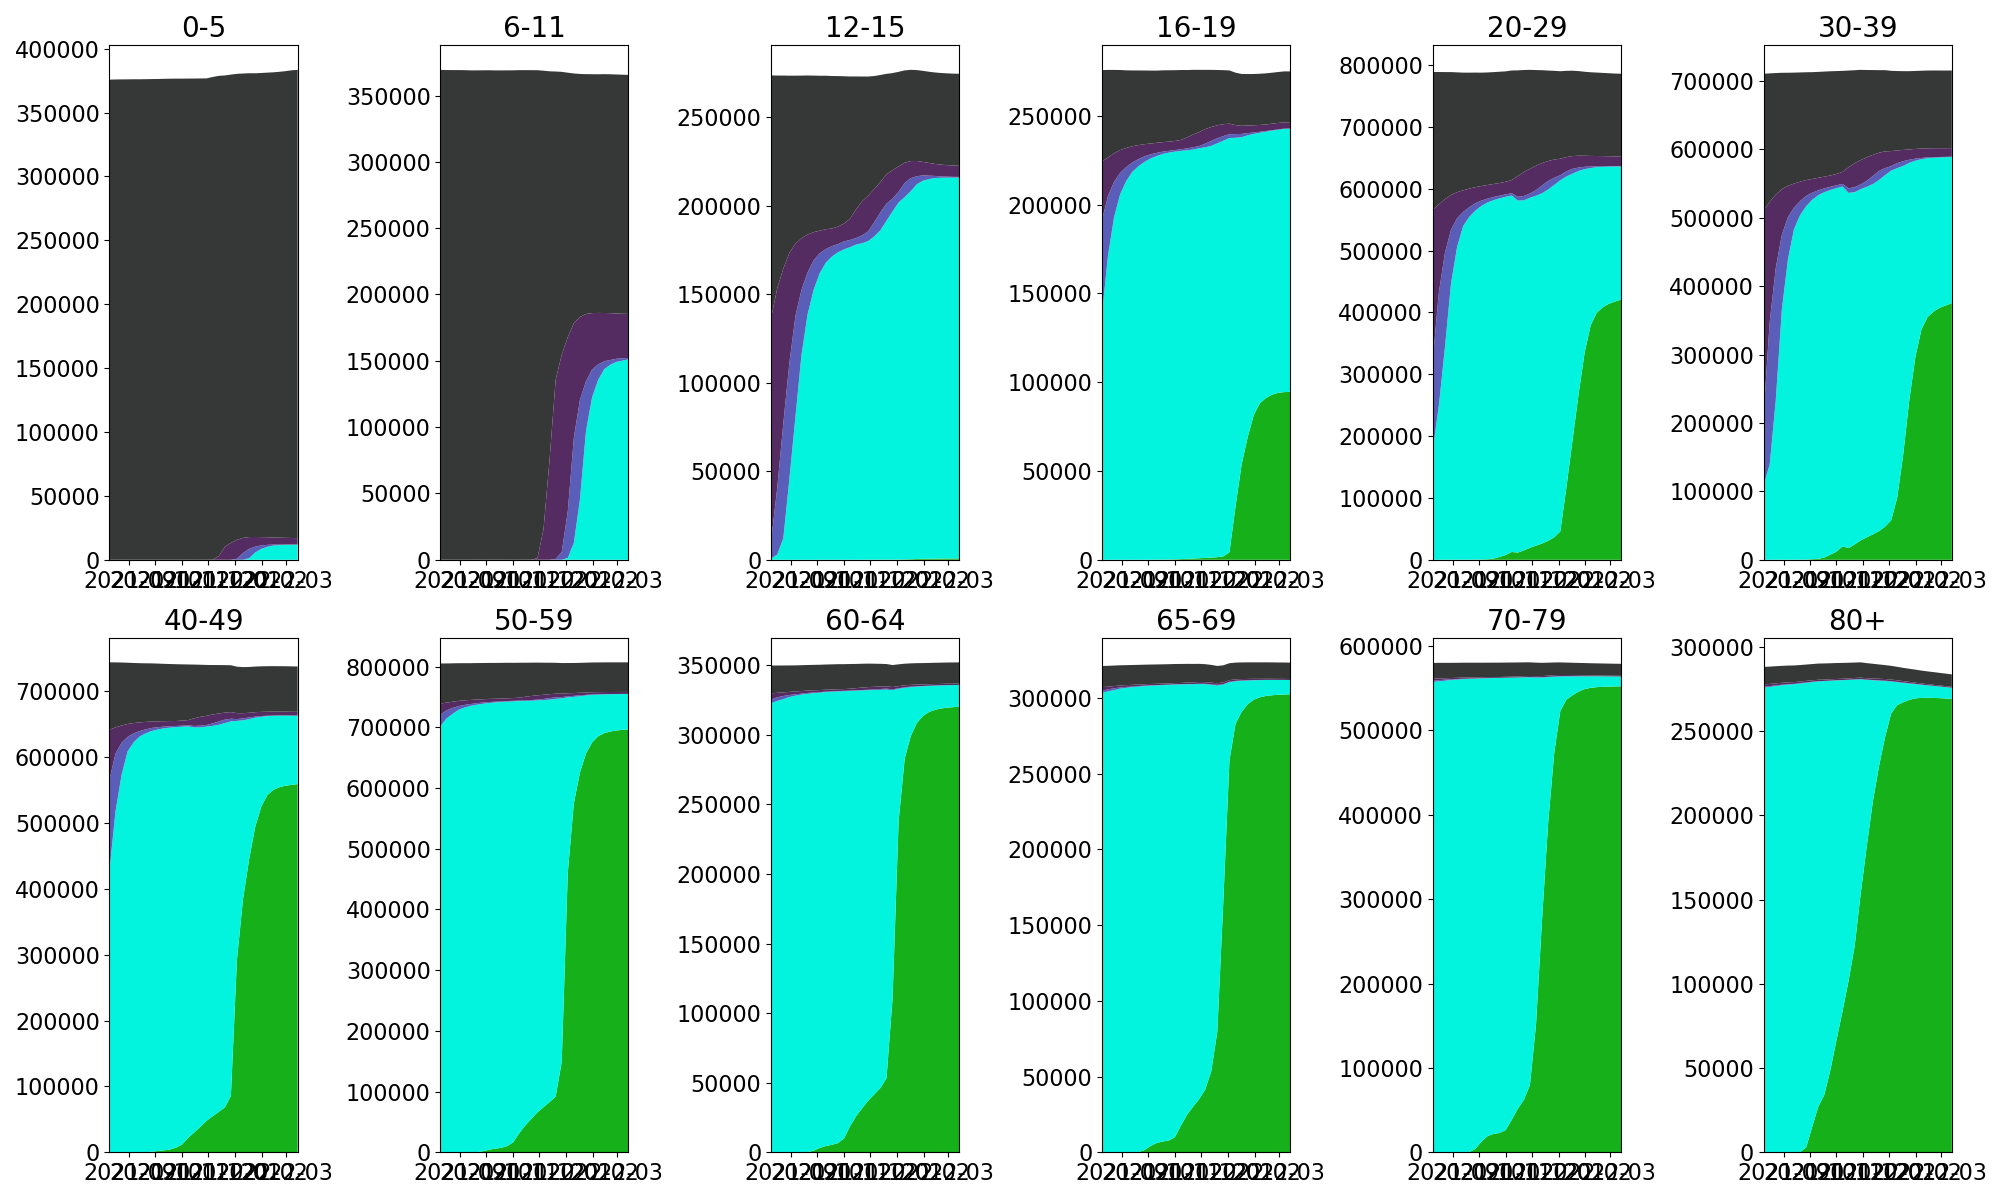

In [100]:

allAges = df_Test_Count.Aldersgruppe.values

curAge = '80+'
curAge = allAges[3]

# fig,ax1 = plt.subplots() 
# fig,allAxes = plt.subplots(len(allAges),1,figsize=(14,20)) 
# fig,allAxes = plt.subplots(2,7,figsize=(20,12)) 
# for i,curAge in enumerate(allAges):

fig,allAxes = plt.subplots(2,6,figsize=(20,12)) 
for i,curAge in enumerate(allAges[:-2]):


    ax1 = allAxes.flatten()[i]

    curPopNone = getPopSizeAll(curStatus=sNone,curAge=curAge)
    curPopOnce = getPopSizeAll(curStatus=sOnce,curAge=curAge)
    curPopBoth = getPopSizeAll(curStatus=sBoth,curAge=curAge)
    curPopFull = getPopSizeAll(curStatus=sFull,curAge=curAge)
    curPopReva = getPopSizeAll(curStatus=sReva,curAge=curAge)

    curPopTwo = curPopBoth-curPopFull-curPopReva


    ax1.stackplot(curDTs,
            curPopReva,
            curPopFull,
            curPopTwo,
            curPopOnce,
            curPopNone,
            colors=[cmap(0),cmap(2),cmap(4),cmap(6),cmap(8)]
            # colors=[cmap(8),cmap(6),cmap(4),cmap(2),cmap(0)]
        )
    ax1.set_title(curAge)

    ax1.set_xlim([curDTs[0],curDTs[-1]])

fig.tight_layout()

In [104]:
# curCount = getTimeSeries(df_Test_Count)
# curInci  = getTimeSeries(df_Test_Inci)

# curCount
# # curCount/curInci
# fig,ax1 = plt.subplots() 
# ax1.plot(100000*curCount/curInci)
# # df3_T.loc[13,'Uge 01-2022_Ingen vaccination']
# # df_Test_Inci

# ax1.plot(df_main.iloc[-31:,1].values,':')
# # ax1.plot(df_main.iloc[:,1].values,':')
# ax1.set_ylim(bottom=0)

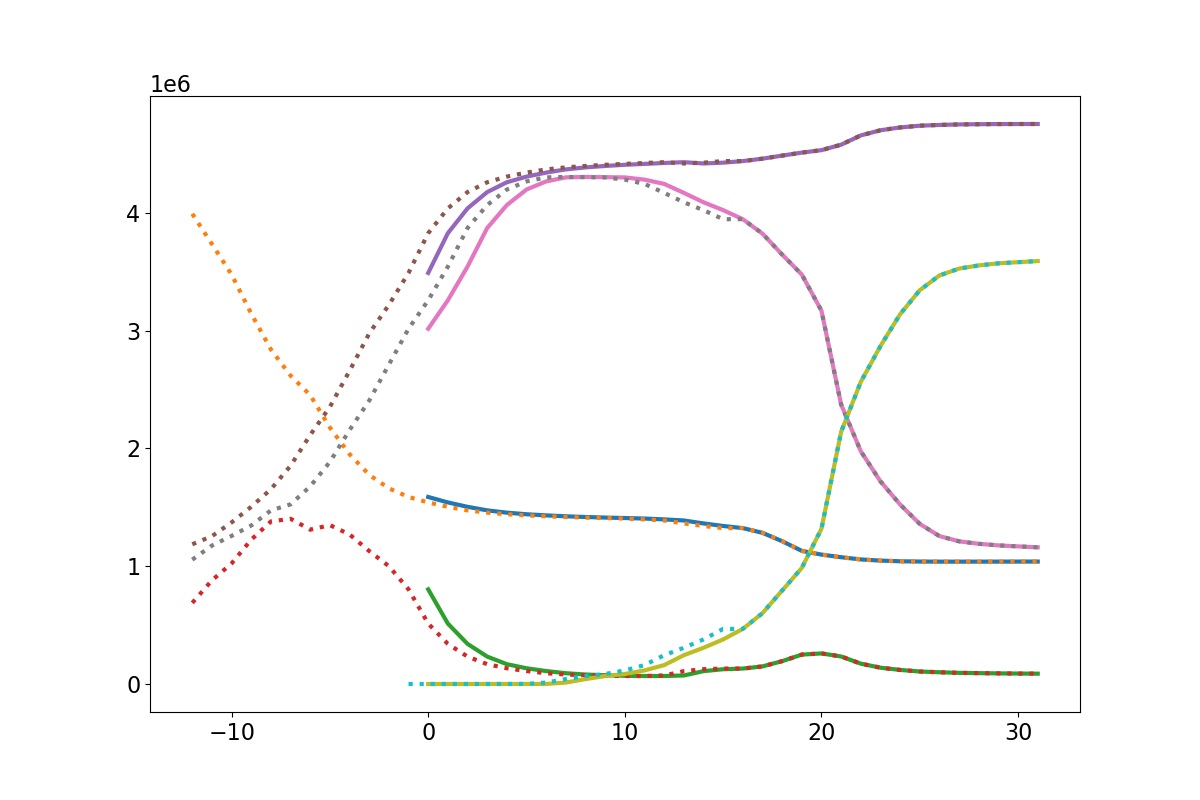

In [103]:
fig,ax = plt.subplots()

curPop = getPopSizeAll(curStatus=sNone,curAge='Alle')
ax.plot(curPop)
ax.plot(np.arange(len(df_main))-(len(df_main)-len(curPop)),df_main.iloc[:,1].values[::-1],':')

curPop = getPopSizeAll(curStatus=sOne,curAge='Alle')
ax.plot(curPop)
ax.plot(np.arange(len(df_main))-(len(df_main)-len(curPop)),df_main.iloc[:,2].values[::-1],':')

curPop = getPopSizeAll(curStatus=sTwo,curAge='Alle')
ax.plot(curPop)
ax.plot(np.arange(len(df_main))-(len(df_main)-len(curPop)),df_main.iloc[:,3].values[::-1],':')

curPop = getPopSizeAll(curStatus=sFull,curAge='Alle')
ax.plot(curPop)
ax.plot(np.arange(len(df_main))-(len(df_main)-len(curPop)),df_main.iloc[:,4].values[::-1],':')

curPop = getPopSizeAll(curStatus=sReva,curAge='Alle')
ax.plot(curPop)
ax.plot(np.arange(len(df_main))-(len(df_main)-len(curPop)),df_main.iloc[:,5].values[::-1],':')

In [148]:
# getPopSizeCount() 
# fig,ax = plt.subplots()
# curPop = getPopSizeAll(curStatus=sNone,curAge='Alle')
# ax.plot(curPop)
# curNoPre = getPopSizeCount(curStatus=sNone,curAge='Alle')
# ax.plot(curNoPre)
# ax.plot(curPop-curNoPre)
# ax.plot(np.arange(len(df_main))-(len(df_main)-len(curPop)),df_main.iloc[:,1].values[::-1],':')

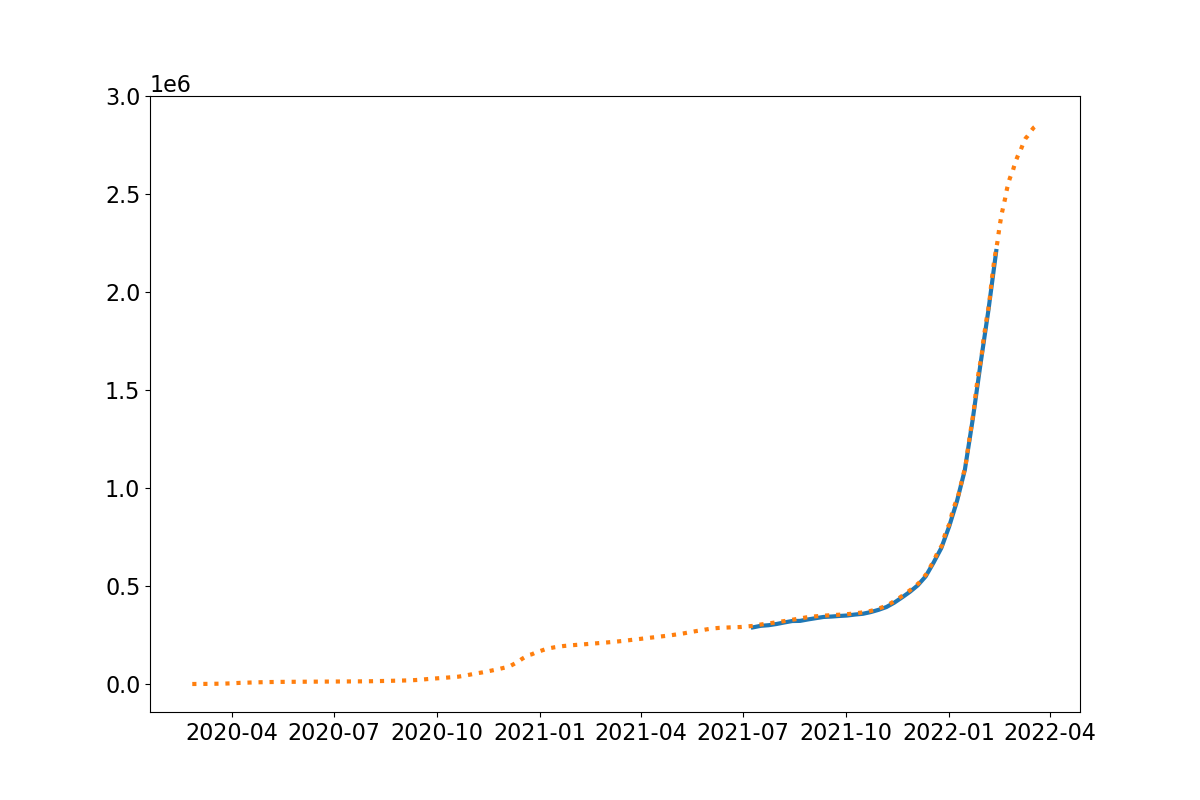

In [147]:
curPopAll = getPopSizeAll(curStatus=sNone,curAge='Alle') + getPopSizeAll(curStatus=sOne,curAge='Alle') + getPopSizeAll(curStatus=sTwo,curAge='Alle')
curPopNoPre = getPopSizeCount(curStatus=sNone,curAge='Alle') + getPopSizeCount(curStatus=sOne,curAge='Alle') + getPopSizeCount(curStatus=sTwo,curAge='Alle')
# ax.plot(curPop)
# curNoPre = getPopSizeCount(curStatus=sNone,curAge='Alle')
# curPopAll
fig,ax = plt.subplots()
ax.plot(curDTs-np.timedelta64(30,'D'),curPopAll-curPopNoPre)
ax.plot(df_inf.index,np.cumsum(df_inf.infected),':')
# ax.plot(pf.rnTime(df_inf.index),pf.rnMean(df_inf.infected)*7,'xkcd:orange',label='Fra regional_DB filer')

In [166]:
df_inf.index

DatetimeIndex(['2020-02-26', '2020-02-27', '2020-02-28', '2020-03-01',
               '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05',
               '2020-03-06', '2020-03-07',
               ...
               '2022-03-12', '2022-03-13', '2022-03-14', '2022-03-15',
               '2022-03-16', '2022-03-17', '2022-03-18', '2022-03-19',
               '2022-03-20', '2022-03-21'],
              dtype='datetime64[ns]', name='Prøvedato', length=754, freq=None)

array([  24167.,   20550.,   15911.,   12219.,   10785.,   11602.,
         14433.,   20561.,   29384.,   41258.,   58880.,   78232.,
         95249.,  113609.,  138645.,  183894.,  231452.,  316557.,
        395582.,  493925.,  684520.,  845782.,  998938., 1124786.,
       1083656.,  946546.,  771332.,  549905.,  372158.])

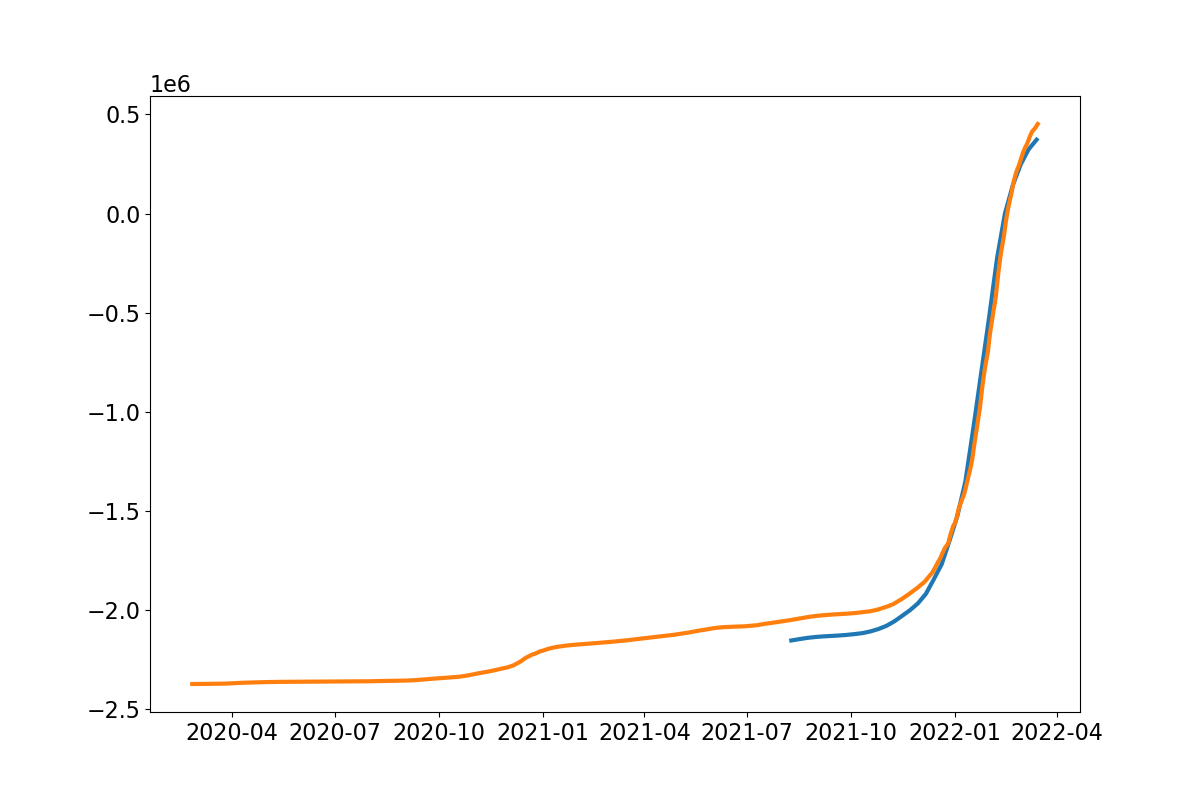

In [177]:

curCase = getTimeSeries(df_Case_Count,curStatus=sNone) +getTimeSeries(df_Case_Count,curStatus=sOne) + getTimeSeries(df_Case_Count,curStatus=sTwo)
fig,ax = plt.subplots()
# ax.plot(curDTs,curCase)
# ax.plot(pf.rnTime(df_inf.index),pf.rnMean(df_inf.infected)*7,'xkcd:orange',label='Fra regional_DB filer')

realCumu = np.cumsum(df_inf.infected)

realDates = df_inf.index.values[:-6]
realCumu = realCumu[:-6]

curCaseCumu = np.cumsum(curCase)
ax.plot(curDTs,curCaseCumu - curCaseCumu[-5])
ax.plot(realDates,realCumu - realCumu[-28])

In [201]:
curPopAll = getPopSizeAll(curStatus=sNone,curAge='Alle') + getPopSizeAll(curStatus=sOne,curAge='Alle') + getPopSizeAll(curStatus=sTwo,curAge='Alle')
curPopNoPre = getPopSizeCount(curStatus=sNone,curAge='Alle') + getPopSizeCount(curStatus=sOne,curAge='Alle') + getPopSizeCount(curStatus=sTwo,curAge='Alle')

# fig,ax = plt.subplots()
# ax.plot(curDTs-np.timedelta64(30,'D'),curPopAll-curPopNoPre)


# print(pf.rnMean(curCase,4)*4)

# print(curPopAll-curPopNoPre)
print(curCase)

print(np.diff(np.cumsum(df_inf.infected).values[3::7])[-12:])

[  6798   6788   6168   4413   3181   2149   2476   2979   3998   4980
   8604  11802  15872  22602  27956  28819  34232  47638  73205  76377
 119337 126663 171548 266972 280599 279819 297396 225842 143489 104605
  75969  48095]
[119308 126657 171518 266962 280594 279812 297389 225838 143492 104602
  75969  48094]


In [269]:
curPosPop = curPopAll-curPopNoPre
print(np.round(curPosPop))
# print(np.cumsum(df_inf.infected).values[3::7][-21:])
print(np.cumsum(df_inf.infected).values[1::7][-13:])

# curPosPop.append(curCase)
asdf = np.append(curPosPop,curPosPop[-1]+(np.cumsum(curCase)-np.cumsum(curCase)[-5])[-4:])
print(np.round(asdf[-12:]))


[ 289121.  297116.  300161.  306296.  314166.  321559.  322220.  329597.
  336080.  342319.  344383.  347361.  349693.  354623.  358459.  367087.
  378626.  392780.  415098.  442223.  470672.  503772.  548982.  618651.
  694072.  804093.  933987. 1093303. 1350122. 1635302. 1907716. 2210702.]
[ 694196  803782  929072 1077127 1324729 1616656 1886042 2190502 2429337
 2595494 2706119 2791593 2843565]
[ 694072.  804093.  933987. 1093303. 1350122. 1635302. 1907716. 2210702.
 2354191. 2458796. 2534765. 2582860.]


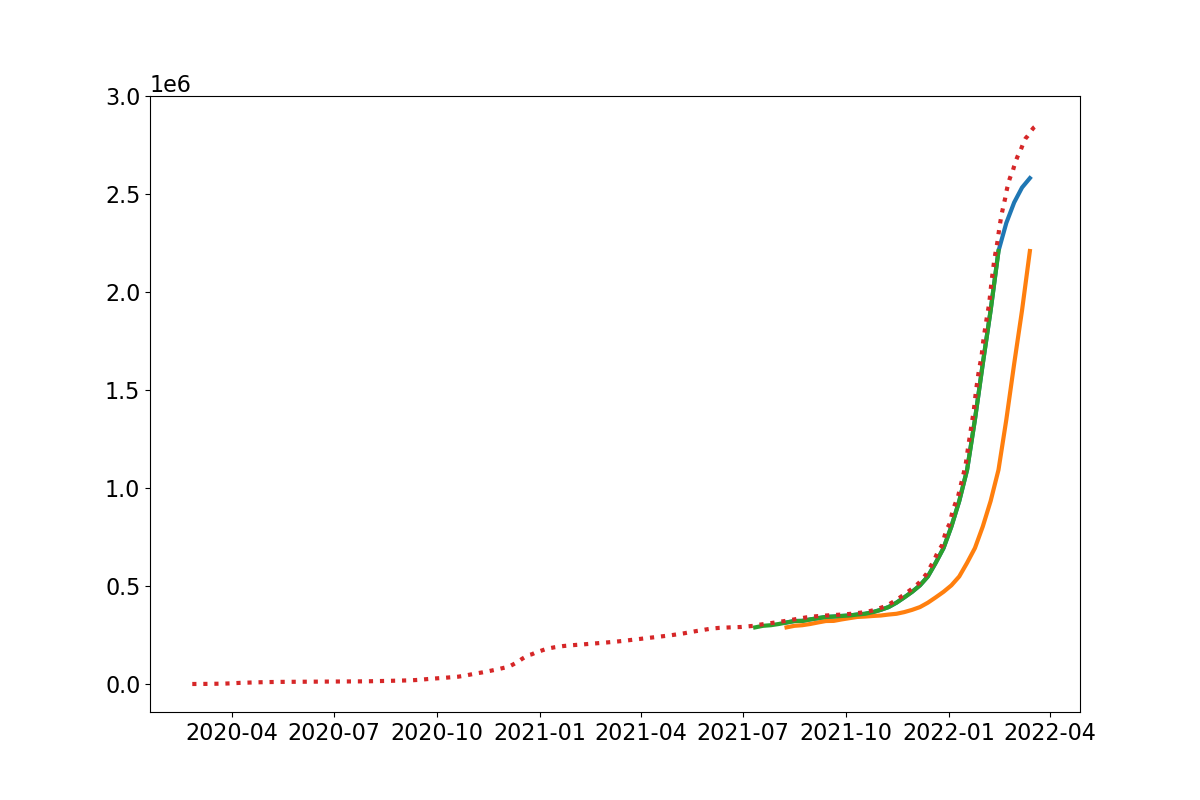

In [270]:

fig,ax = plt.subplots()
ax.plot(curDTs,asdf[4:])
ax.plot(curDTs,curPosPop)
ax.plot(curDTs-np.timedelta64(28,'D'),curPosPop)
ax.plot(df_inf.index,np.cumsum(df_inf.infected),':')

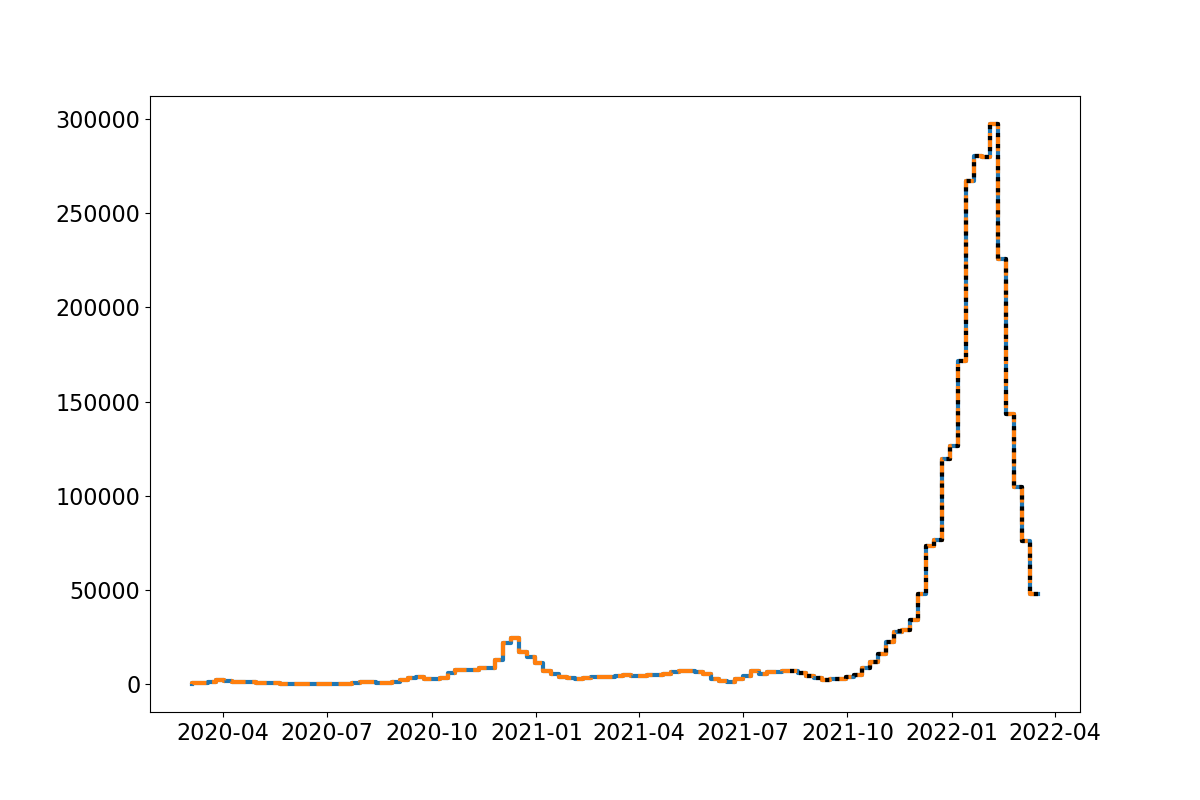

In [298]:
fig,ax = plt.subplots()
# ax.plot(curDTs,curCase)
# ax.plot(pf.rnTime(df_inf.index,7)[3::7],(pf.rnMean(df_inf.infected,7)*7)[3::7],color='xkcd:orange',label='Fra regional_DB filer')
# ax.step(pf.rnTime(df_inf.index,7)[::7],(pf.rnMean(df_inf.infected,7)*7)[::7],color='xkcd:orange',label='Fra regional_DB filer')
# ax.step(pf.rnTime(df_inf.index,7)[1::7],(pf.rnMean(df_inf.infected,7)*7)[1::7])
# ax.step(pf.rnTime(df_inf.index,7)[2::7],(pf.rnMean(df_inf.infected,7)*7)[2::7])
# ax.step(pf.rnTime(df_inf.index,7)[3::7],(pf.rnMean(df_inf.infected,7)*7)[3::7])
ax.step(pf.rnTime(df_inf.index,7)[4::7],(pf.rnMean(df_inf.infected,7)*7)[4::7])
ax.step(df_inf.index[3:][4::7],(pf.rnMean(df_inf.infected,7)*7)[4::7],'--')
# ax.step(pf.rnTime(df_inf.index,7)[5::7],(pf.rnMean(df_inf.infected,7)*7)[5::7])
# ax.step(pf.rnTime(df_inf.index,7)[6::7],(pf.rnMean(df_inf.infected,7)*7)[6::7])
ax.step(curDTs+np.timedelta64(3,'D'),curCase,color='k',linestyle=':')


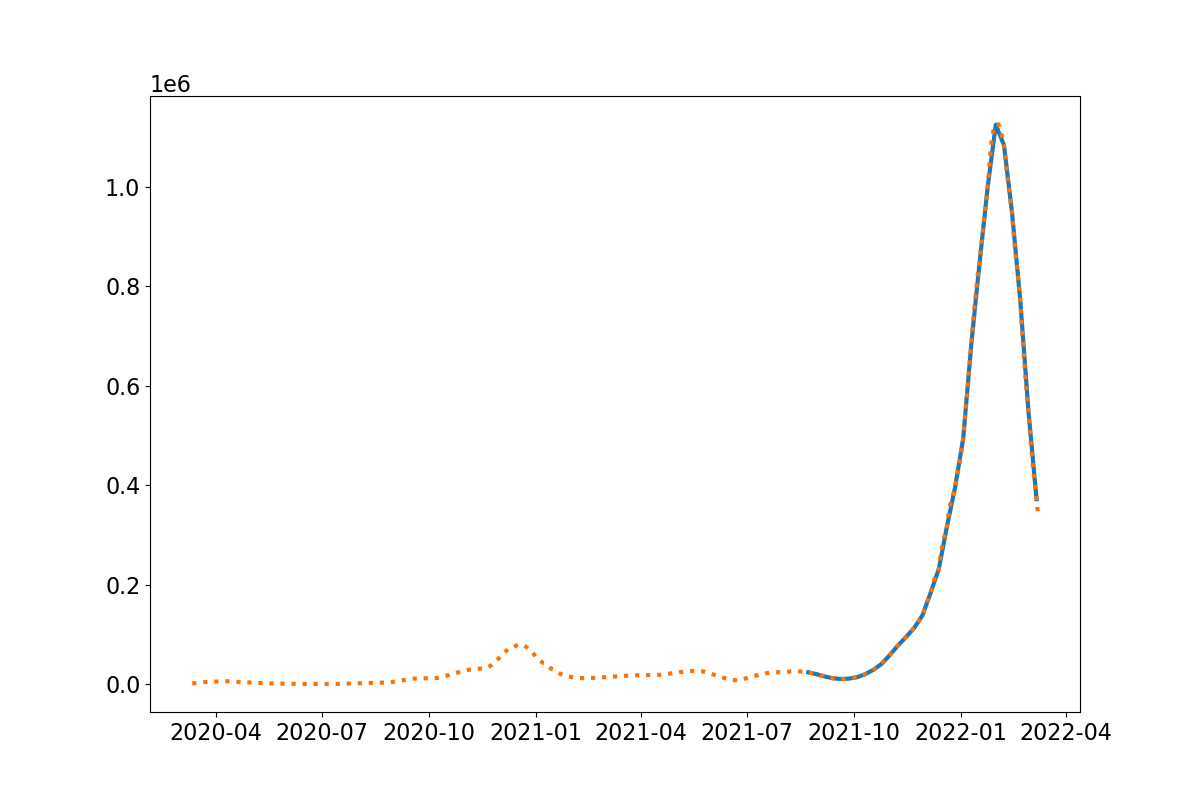

In [184]:
fig,ax = plt.subplots()
ax.plot(curDTs[2:-1],pf.rnMean(curCase,4)*4)

ax.plot(pf.rnTime(df_inf.index,28),pf.rnMean(df_inf.infected,28)*28,':',color='xkcd:orange',label='Fra regional_DB filer')

In [54]:

# weekDTs = [np.datetime64(datetime.datetime.strptime(d[-4:] + '-W'+d[4:6]+'-1', "%Y-W%W-%w")) for d in df1.Ugenummer]

# curOrder = np.argsort(weekDTs)
# weekDTs = np.array(weekDTs)
# weekDTs = weekDTs[curOrder]
        
sNone = 'Ingen vaccination'        
sOne = 'Første vaccination'  
sTwo = 'Anden vaccination'
sFull = 'Fuld effekt efter primært forløb'   
sReva = 'Fuld effekt efter revaccination'


ageGroups = df_Test_Inci.Aldersgruppe.values
# print(ageGroups)
# weekNames = df1.Ugenummer
weekNames = df1.Ugenummer.values[curOrder]
weekNamesShort = [x[4:6] for x in weekNames]
wInt = [int(x[4:6]) for x in weekNames]
wIntRange = np.arange(len(wInt))

allDates = np.array(weekDTs)[curOrder]
print(weekNames)

# Make function for gettings particular parts
def getTimeSeriesSingle(thisdf=df2_C,curStatus='Ingen vaccination',curAge='Alle',weekNames=weekNames):
    
    agedf = thisdf[thisdf.Aldersgruppe==curAge]
    allVals = []
    for curWeek in weekNames:
        toAdd = agedf[curWeek+'_'+curStatus].values[0]
        allVals.append(toAdd)
    allVals = np.array(allVals)

    return allVals

    

def getTimeSeries(thisdf=df2_C,curStatus='Ingen vaccination',curAge='Alle',weekNames=weekNames):
    # If curAge is just a string, return the given array
    if (type(curAge)==str):
        agedf = thisdf[thisdf.Aldersgruppe==curAge]
        allVals = []
        for curWeek in weekNames:
            toAdd = agedf[curWeek+'_'+curStatus].values[0]
            allVals.append(toAdd)
        allVals = np.array(allVals)
        
        return allVals 
        
    else:
        # If curAge is not a string, it is assumed to be a list of strings
        totCount = []
        for thisAge in curAge:
            agedf = thisdf[thisdf.Aldersgruppe==thisAge]
            allVals = []
            for curWeek in weekNames:
                toAdd = agedf[curWeek+'_'+curStatus].values[0]
                allVals.append(toAdd)
            allVals = np.array(allVals)
            if len(totCount) == 0:
                totCount = allVals 
            else:
                totCount = totCount + allVals
        return totCount

def getTimeSeriesAll(thisdf=df2_C,curAge='Alle',weekNames=weekNames):
    return getTimeSeries(thisdf,sNone,curAge,weekNames)+getTimeSeries(thisdf,sOne,curAge,weekNames)+getTimeSeries(thisdf,sTwo,curAge,weekNames)

['Uge 21-2021' 'Uge 22' 'Uge 23' 'Uge 24' 'Uge 25' 'Uge 26' 'Uge 27'
 'Uge 28' 'Uge 29' 'Uge 30' 'Uge 31' 'Uge 32' 'Uge 33' 'Uge 34' 'Uge 35'
 'Uge 36']


In [55]:
# Go through each tuesday, as long back as possible, and grab the last row

# Start by taking all data from the most recent file
df_main = dfRecent.copy()

# allRows = [] 
colNamesToChange = {
'antal_personer_alle_Fuld vaccineeffekt': 'antal_personer_alle_Fuld effekt efter primært forløb',
'antal_personer_Fuld vaccineeffekt': 'antal_personer_Fuld effekt efter primært forløb',
'antal_cases_Fuld vaccineeffekt': 'antal_cases_Fuld effekt efter primært forløb',
'antal_repositive_Fuld vaccineeffekt': 'antal_repositive_Fuld effekt efter primært forløb',
'antal_indlagte_Fuld vaccineeffekt': 'antal_indlagte_Fuld effekt efter primært forløb',
'antal_tests_Fuld vaccineeffekt': 'antal_tests_Fuld effekt efter primært forløb',
'antal_tests_total_Fuld vaccineeffekt': 'antal_tests_total_Fuld effekt efter primært forløb',
}

maxWeeksBack = 50
for k in range(1,maxWeeksBack):
    curTue = mostRecentTuesday - np.timedelta64(7*k,'D')
    curTuePath = 'SSI_data_'+str(curTue)

    dirPath = path_data + curTuePath + '/'
    filePath = dirPath+'gennembrudsinfektioner_table1.csv'
    if os.path.exists(filePath):
        df1 = pd.read_csv(filePath,delimiter=';')
    else:
        continue

    # Check length of "ugenummer" columns
    if (len(df1.iloc[0,0]) == 11):
        # If length is 11, the year was included

        # Figure out order, to be able to get oldest
        weekDTs = [np.datetime64(datetime.datetime.strptime(d[-4:] + '-W'+d[4:6]+'-1', "%Y-W%W-%w")) for d in df1.Ugenummer]
        curOrder = np.argsort(weekDTs)
        df1 = df1.rename(columns=colNamesToChange) 

        oldestIndex = np.where(curOrder == 0)[0][0]
        # print(df1.iloc[oldestIndex,0])
        # display(df1.iloc[oldestIndex,1])

        # allRows.append(df1.iloc[oldestIndex,:])
        # df_main = df_main.append(df1.iloc[oldestIndex,:])
        df_main = pd.concat([df_main,df1.iloc[oldestIndex:oldestIndex+1,:]])
    else:
        # display(df1)

        # Rename weeknumber to have year
        df1.iloc[-1,0] = df1.iloc[-1,0] + '-2021'
        # And rename "Fuld Effekt" columns
        df1 = df1.rename(columns=colNamesToChange) 



        # print(df1.iloc[-1,0])
        # allRows.append(df1.iloc[-1,:])
        # df_main = df_main.append(df1.iloc[-1,:])
        df_main = pd.concat([df_main,df1.iloc[-1:,:]])


In [56]:
# df2_C/df3_C
case = df2_C.iloc[:,1:4]
inci = df3_C.iloc[:,1:4]
popSizes = 100000*case/inci 
# popSizes.sum(axis=1)
popSizes

# inci/100000
# popSizes
# df3_C.iloc[:,1:4]
# df2_C

case = df2_T.iloc[:,1:4]
inci = df3_T.iloc[:,1:4]
popSizes = 100000*case/inci 
# popSizes.sum(axis=1)
popSizes

Uge 11-2022_Ingen vaccination  Uge 11-2022_Første vaccination  \
0                    3.664997e+05                     5011.135857   
1                    1.802080e+05                    33178.446238   
2                    5.191757e+04                     6336.793852   
3                    2.864368e+04                     3503.896575   
4                    1.337447e+05                    15673.736744   
5                    1.134344e+05                    12565.914956   
6                    6.885177e+04                     5632.967685   
7                    4.876924e+04                     3253.990622   
8                    1.527022e+04                      962.996353   
9                    1.082118e+04                      651.000651   
10                   1.423221e+04                      791.002704   
11                   7.407044e+03                      541.003562   
12                   4.930840e+05                    49914.753147   
13                   1.039815e+06                    88104.877579   

    Uge 11-2022_Anden vaccination  
0                    1.193307e+04  
1                    1.521960e+05  
2                    2.161677e+05  
3                    2.429166e+05  
4                    6.366280e+05  
5                    5.891444e+05  
6                    6.629639e+05  
7                    7.550226e+05  
8                    3.359354e+05  
9                    3.117630e+05  
10                   5.638236e+05  
11                   2.758487e+05  
12                   4.590194e+06  
13                   4.754371e+06

In [57]:

dfRecent

Ugenummer  antal_personer_alle_Ingen vaccination  \
0   Uge 11-2022                                1039813   
1   Uge 10-2022                                1039656   
2   Uge 09-2022                                1039375   
3   Uge 08-2022                                1039154   
4   Uge 07-2022                                1039023   
5   Uge 06-2022                                1039074   
6   Uge 05-2022                                1039952   
7   Uge 04-2022                                1042232   
8   Uge 03-2022                                1047793   
9   Uge 02-2022                                1057845   
10  Uge 01-2022                                1076601   
11  Uge 52-2021                                1098880   
12  Uge 51-2021                                1130426   
13  Uge 50-2021                                1212832   
14  Uge 49-2021                                1283901   
15  Uge 48-2021                                1323831   

    antal_personer_alle_Første vaccination  \
0                                    88103   
1                                    89027   
2                                    90477   
3                                    92614   
4                                    94975   
5                                    99923   
6                                   106442   
7                                   119878   
8                                   138814   
9                                   173251   
10                                  234118   
11                                  259914   
12                                  249966   
13                                  194277   
14                                  149639   
15                                  131371   

    antal_personer_alle_Anden vaccination  \
0                                 4754346   
1                                 4754236   
2                                 4753785   
3                                 4752489   
4                                 4750858   
5                                 4746313   
6                                 4739899   
7                                 4725131   
8                                 4701229   
9                                 4657344   
10                                4578663   
11                                4532338   
12                                4511467   
13                                4485961   
14                                4460048   
15                                4439467   

    antal_personer_alle_Fuld effekt efter primært forløb  \
0                                             1160713      
1                                             1168552      
2                                             1176973      
3                                             1190534      
4                                             1211675      
5                                             1255976      
6                                             1359597      
7                                             1524344      
8                                             1720764      
9                                             1976724      
10                                            2373766      
11                                            3169642      
12                                            3476474      
13                                            3646141      
14                                            3823737      
15                                            3946264      

    antal_personer_alle_Fuld effekt efter revaccination  \
0                                             3590666     
1                                             3581393     
2                                             3571479     
3                                             3553908     
4                                             3526883     
5                                             3468636     
6                                   

In [58]:
# df2_C
# 5333/
# dfRecent
case = 5333
pop = 1038331
pop = 599151
100000*case/pop

100000*case / 890.1
# df3_C

case = df2_C.iloc[:,1:4]
inci = df3_C.iloc[:,1:4] 
100000*case/inci

Uge 11-2022_Ingen vaccination  Uge 11-2022_Første vaccination  \
0                   244585.987261                     1916.626737   
1                    49264.378065                     6747.891284   
2                    13653.413353                     1461.988304   
3                    10804.553347                     1239.925604   
4                    70736.180246                     6943.613073   
5                    57916.808342                     5124.747134   
6                    36686.923250                     2577.952369   
7                    31622.602385                     1947.040498   
8                    11303.599951                      679.001867   
9                     8979.591837                      493.989791   
10                   12560.128274                      641.951533   
11                    6713.780919                      446.030330   
12                  260986.328125                    21556.712963   
13                  554820.415879                    30220.658778   

    Uge 11-2022_Anden vaccination  
0                    7.599145e+03  
1                    6.585191e+04  
2                    8.239128e+04  
3                    9.706202e+04  
4                    3.572817e+05  
5                    3.107300e+05  
6                    3.681974e+05  
7                    5.280182e+05  
8                    2.591929e+05  
9                    2.607882e+05  
10                   4.987923e+05  
11                   2.505862e+05  
12                   3.013005e+06  
13                   3.086548e+06

In [59]:
# firstAlleIndex = np.where(df_main.columns == 'antal_personer_alle_Ingen vaccination')[0][0]
# totAlle = df_main.iloc[:,firstAlleIndex:firstAlleIndex+3].sum(axis=1)

# firstPersIndex = np.where(df_main.columns == 'antal_personer_Ingen vaccination')[0][0]
# totPers = df_main.iloc[:,firstPersIndex:firstPersIndex+3].sum(axis=1)

# firstCaseIndex = np.where(df_main.columns == 'antal_cases_Ingen vaccination')[0][0]
# totCase = df_main.iloc[:,firstCaseIndex:firstCaseIndex+3].sum(axis=1).values


# fourWeekCase = np.cumsum(totCase[4:])-np.cumsum(totCase[:-4])

# prevPos = np.cumsum(totCase) + (totAlle[0]-totPers[0])

# curPos = prevPos[4:] - prevPos[:-4]

# toShow = np.concatenate([(totAlle-totPers).values[5:],prevPos[-5:]])

# fig,ax1 = plt.subplots()

# # curDif = totAlle-totPers 
# # ax1.plot(allDTs-np.timedelta64(35,'D'),curDif)
# # ax1.plot(allDTs,np.cumsum(totCase)+curDif[0])

# # ax1.plot(allDTs,totAlle-totPers)
# # ax1.plot(allDTs,totAlle-totPers + totCase)
# # ax1.plot(allDTs,totAlle)
# # ax1.plot(allDTs,totPers)
# # ax1.plot(allDTs,totPers+prevPos)
# # ax1.plot(allDTs[5:],totPers[5:]+prevPos[:-5])

# # ax1.plot(allDTs,totAlle-totPers)
# # ax1.plot(allDTs[5:],totAlle[5:]-totPers[5:]+prevPos[:-5])
# ax1.plot(allDTs-np.timedelta64(4*7,'D'),totAlle-totPers)#+np.cumsum(totCase))
# ax1.plot(allDTs,prevPos,'*-')
# ax1.plot(allDTs,toShow)
# ax1.plot(df_inf.index,np.cumsum(df_inf.infected),':',label='Fra regional_DB filer')

# # ax1.plot(allDTs[4:],curPos)
# # ax1.plot(df_inf.index,df_inf.infected,label='Fra regional_DB filer')

# # ax1.plot(allDTs,totPers+totCase,'*-')
# # ax1.plot(allDTs,totAlle-totCase,'*-')
# # ax1.plot(allDTs[4:],totAlle[4:]-fourWeekCase,'*-')
# # ax1.plot(allDTs[4:],totPers[4:]+fourWeekCase)

# # ax1.set_ylim([5.7e6,6.0e6])

# # ax1.plot(allDTs,totCase)
# # ax1.plot(allDTs[4:],np.cumsum(totCase[4:])-np.cumsum(totCase[:-4]))

# Old below

In [ ]:
# # Go through each tuesday, as long back as possible, and grab the last row

# # Start by taking all data from the most recent file
# df_main = dfRecent.copy()

# # allRows = [] 
# colNamesToChange = {
# 'antal_personer_alle_Fuld vaccineeffekt': 'antal_personer_alle_Fuld effekt efter primært forløb',
# 'antal_personer_Fuld vaccineeffekt': 'antal_personer_Fuld effekt efter primært forløb',
# 'antal_cases_Fuld vaccineeffekt': 'antal_cases_Fuld effekt efter primært forløb',
# 'antal_repositive_Fuld vaccineeffekt': 'antal_repositive_Fuld effekt efter primært forløb',
# 'antal_indlagte_Fuld vaccineeffekt': 'antal_indlagte_Fuld effekt efter primært forløb',
# 'antal_tests_Fuld vaccineeffekt': 'antal_tests_Fuld effekt efter primært forløb',
# 'antal_tests_total_Fuld vaccineeffekt': 'antal_tests_total_Fuld effekt efter primært forløb',
# }

# maxWeeksBack = 50
# for k in range(1,maxWeeksBack):
#     curTue = mostRecentTuesday - np.timedelta64(7*k,'D')
#     curTuePath = 'SSI_data_'+str(curTue)

#     dirPath = path_data + curTuePath + '/'
#     filePath = dirPath+'gennembrudsinfektioner_table1.csv'
#     if os.path.exists(filePath):
#         df1 = pd.read_csv(filePath,delimiter=';')
#     else:
#         continue

#     # Check length of "ugenummer" columns
#     if (len(df1.iloc[0,0]) == 11):
#         # If length is 11, the year was included

#         # Figure out order, to be able to get oldest
#         weekDTs = [np.datetime64(datetime.datetime.strptime(d[-4:] + '-W'+d[4:6]+'-1', "%Y-W%W-%w")) for d in df1.Ugenummer]
#         curOrder = np.argsort(weekDTs)
#         df1 = df1.rename(columns=colNamesToChange) 

#         oldestIndex = np.where(curOrder == 0)[0][0]
#         # print(df1.iloc[oldestIndex,0])
#         # display(df1.iloc[oldestIndex,1])

#         # allRows.append(df1.iloc[oldestIndex,:])
#         # df_main = df_main.append(df1.iloc[oldestIndex,:])
#         df_main = pd.concat([df_main,df1.iloc[oldestIndex:oldestIndex+1,:]])
#     else:
#         # display(df1)

#         # Rename weeknumber to have year
#         df1.iloc[-1,0] = df1.iloc[-1,0] + '-2021'
#         # And rename "Fuld Effekt" columns
#         df1 = df1.rename(columns=colNamesToChange) 



#         # print(df1.iloc[-1,0])
#         # allRows.append(df1.iloc[-1,:])
#         # df_main = df_main.append(df1.iloc[-1,:])
#         df_main = pd.concat([df_main,df1.iloc[-1:,:]])


In [ ]:
# # unva = df_main.iloc[:,1]
# unva_neg =  df_main.iloc[:,6]
# once_neg =  df_main.iloc[:,7]
# both_neg =  df_main.iloc[:,8]
# full_neg =  df_main.iloc[:,9].fillna(0) +  df_main.iloc[:,-5].fillna(0)
# reva_neg =  df_main.iloc[:,10]

# unva_pos = unva - df_main.iloc[:,6]
# once_pos = once - df_main.iloc[:,7]
# both_pos = both - df_main.iloc[:,8]
# full_pos = full - df_main.iloc[:,9].fillna(0) -  df_main.iloc[:,-5].fillna(0)
# reva_pos = reva - df_main.iloc[:,10]

# # unva = df_main.iloc[:,1]
# # once = df_main.iloc[:,2]
# # both = df_main.iloc[:,3]
# # full_pri = df_main.iloc[:,4].fillna(0)
# # full_old = df_main.iloc[:,-4].fillna(0)
# # full = full_pri + full_old
# # reva = df_main.iloc[:,5].fillna(0)



# fig,(ax1,ax2) = plt.subplots(2,1,sharex=True)
# # ax1.fill_between(allDTs,unva)
# # ax1.fill_between(allDTs,unva_pos)
# # ax2.fill_between(allDTs,unva/unva)
# # ax2.fill_between(allDTs,unva_pos/unva)

# # ax1.fill_between(allDTs,once)
# # ax1.fill_between(allDTs,once_pos)
# # ax2.fill_between(allDTs,once/once)
# # ax2.fill_between(allDTs,once_pos/once)


# # ax1.fill_between(allDTs,both)
# # ax1.fill_between(allDTs,both_pos)
# # ax2.fill_between(allDTs,both/both)
# # ax2.fill_between(allDTs,both_pos/both)


# ax1.fill_between(allDTs,reva)
# ax1.fill_between(allDTs,reva_pos)
# ax2.fill_between(allDTs,reva/reva)
# ax2.fill_between(allDTs,reva_pos/reva)

# ax1.set_ylim(bottom=0)

In [ ]:

# cmap = pf.getColormapFromList(['xkcd:green','xkcd:cyan','xkcd:purple','xkcd:dark grey'],8)
# allLabels= ['Booster,\nprevious infection','Booster,\nno known infection','Two doses,\nprevious infection','Two doses,\nno known infection','One dose,\nprevious infection','One dose,\nno known infection','Unvaccinated,\nprevious infection','Unvaccinated,\nno known infection']
# fig,ax1 = plt.subplots()
# ax1.stackplot(allDTs,
#                 100*(reva_pos)/popSize,
#                 100*(reva_neg)/popSize,
#                 # 100*(full_pos)/popSize,
#                 # 100*(full_neg)/popSize,
#                 # 100*(both_pos-full_pos-reva_pos)/popSize,
#                 # 100*(both_neg-full_neg-reva_neg)/popSize,
#                 100*(both_pos-reva_pos)/popSize,
#                 100*(both_neg-reva_neg)/popSize,
#                 100*(once_pos)/popSize,
#                 100*(once_neg)/popSize,
#                 100*(unva_pos)/popSize,
#                 100*(unva_neg)/popSize,
#                 # colors=['xkcd:dark green','xkcd:green','xkcd:cyan','xkcd:blue','m'],
#                 # labels=['Full effect after booster','Full effect after two doses','Two doses','One dose','Unvaccinated']
#                 colors = [cmap(k) for k in range(0,8)],
#                 labels= allLabels 
#         )
        
# ax1.set_ylim([0,100])
# # ax1.legend(loc='upper left')
# # ax1.legend(bbox_to_anchor=(1.05,0.5),loc='center left')
# ax1.legend(bbox_to_anchor=(-0.05,0.5),loc='center right')

# ax1.set_xlim([np.min(allDTs),np.max(allDTs)])

# ax1.yaxis.set_label_position("right")
# ax1.yaxis.tick_right()


# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

# fig.tight_layout()

# fig.savefig(path_figs+'Immunity/TotalPopulationImmunity')

In [ ]:
# fig,ax1 = plt.subplots()
# ax1.plot(allDTs,100*(reva_pos)/popSize,label='reva_pos')
# ax1.plot(allDTs,100*(both_pos-reva_pos)/popSize,label='both_pos')
# ax1.plot(allDTs,100*(once_pos)/popSize,label='once_pos')
# ax1.plot(allDTs,100*(unva_pos)/popSize,label='unva_pos')
# ax1.legend()

In [ ]:
# curStatus = 'Ingen vaccination'
# curdf = df_main[::-1]
# curDates = allDTs[::-1]
# curAlle = curdf['antal_personer_alle_'+curStatus]
# curPers = curdf['antal_personer_'+curStatus]
# curCase = curdf['antal_cases_'+curStatus]
# curRepo = curdf['antal_repositive_'+curStatus]

# fig,ax1 = plt.subplots()

# ax1.plot(curDates,curAlle)
# ax1.plot(curDates,curPers)
# ax1.plot(curDates,curCase)
# ax1.plot(curDates,curRepo)


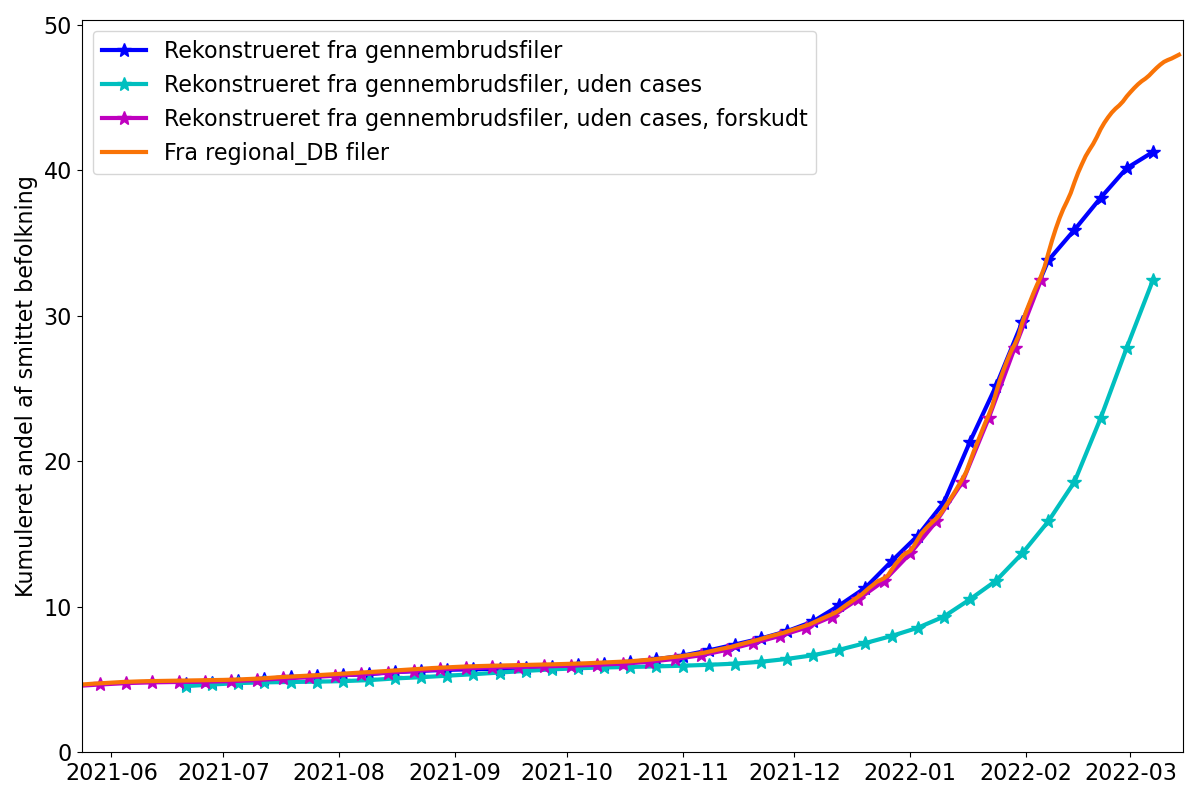

In [ ]:

curdf = df_main[::-1]
curDates = allDTs[::-1]


alleSum = curdf.iloc[:,1:4].sum(axis=1).values
antalSum = curdf.iloc[:,6:9].sum(axis=1).values
antalCase = curdf.iloc[:,11:14].sum(axis=1).values
curPosi = np.cumsum(antalCase)[4:] -  np.cumsum(antalCase)[:-4]

# fig,ax1 = plt.subplots()
# ax1.plot(curDates,antalCase)
# ax1.plot(curDates[4:],curPosi)

antalRepo = curdf.iloc[:,31:34].sum(axis=1).values
curRepo = np.cumsum(antalRepo)[4:] -  np.cumsum(antalRepo)[:-4]

# fig,ax1 = plt.subplots()
# ax1.plot(curDates,antalRepo)
# ax1.plot(curDates[4:],curRepo)

fig,ax1 = plt.subplots()

allPos = alleSum[4:] - antalSum[4:] + curPosi - curRepo
ax1.plot(curDates[4:],100*allPos/alleSum[4:],'b*-',label='Rekonstrueret fra gennembrudsfiler')
ax1.plot(curDates[4:],100*(alleSum[4:] - antalSum[4:])/alleSum[4:],'c*-',label='Rekonstrueret fra gennembrudsfiler, uden cases')
ax1.plot(curDates[4:]-np.timedelta64(30,'D'),100*(alleSum[4:] - antalSum[4:])/alleSum[4:],'m*-',label='Rekonstrueret fra gennembrudsfiler, uden cases, forskudt')

# allPosRepo = alleSum[4:] - antalSum[4:] + curPosi + curRepo
# ax1.plot(curDates[4:],100*allPosRepo/alleSum[4:],'*-',color='xkcd:cyan')



dkPop = popSize.values[-1]
ax1.plot(df_inf.index,100*np.cumsum(df_inf.infected)/dkPop,'xkcd:orange',label='Fra regional_DB filer')
# ax1.plot(df_inf.index+np.timedelta64(30,'D'),100*np.cumsum(df_inf.infected)/dkPop,'r:',label='Cumulative sum\nof all cases,\nshifted 30 days forward')


ax1.set_xlim([curDates[0],np.datetime64('today')])
ax1.legend()

ax1.set_ylabel('Kumuleret andel af smittet befolkning')

ax1.set_ylim(bottom=0)
fig.tight_layout()

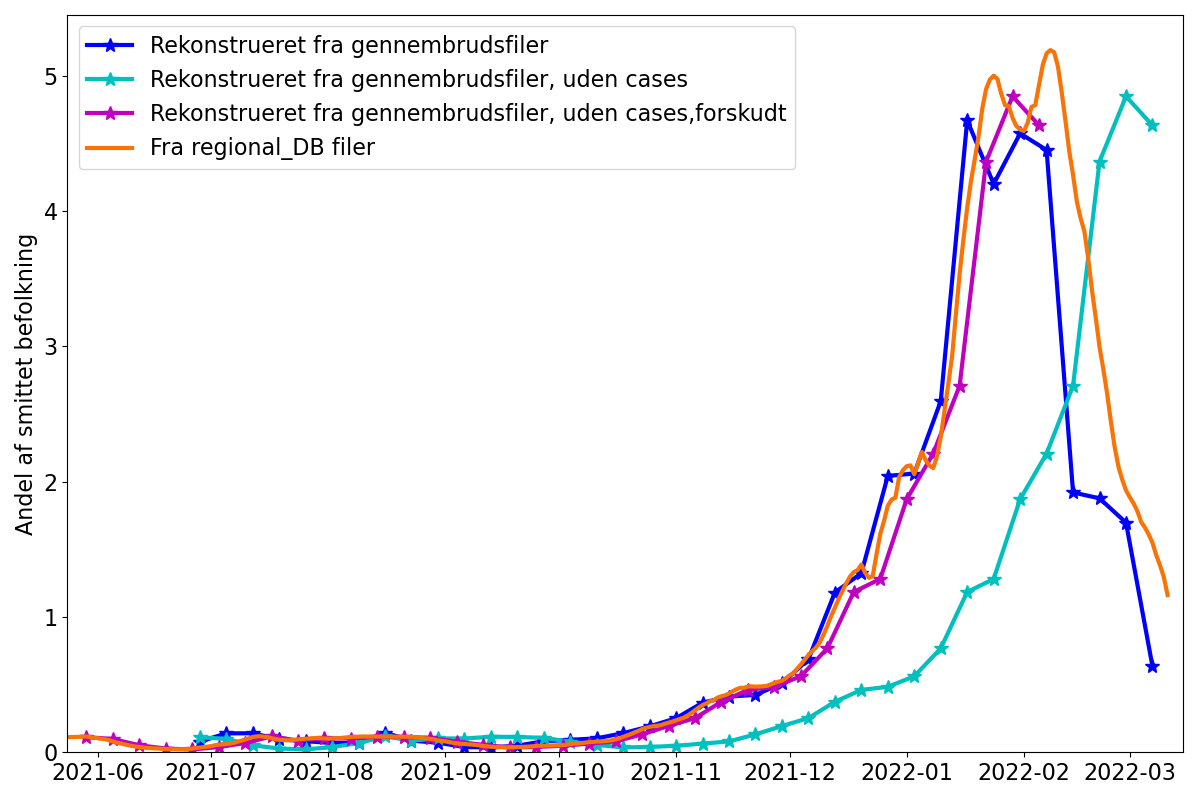

In [ ]:
fig,ax1 = plt.subplots() 


allPos = alleSum[4:] - antalSum[4:] + curPosi + curRepo
ax1.plot(curDates[5:],100*np.diff(allPos)/alleSum[5:],'b*-',label='Rekonstrueret fra gennembrudsfiler')
ax1.plot(curDates[5:],100*np.diff(alleSum[4:] - antalSum[4:])/alleSum[5:],'c*-',label='Rekonstrueret fra gennembrudsfiler, uden cases')
ax1.plot(curDates[5:]-np.timedelta64(30,'D'),100*np.diff(alleSum[4:] - antalSum[4:])/alleSum[5:],'m*-',label='Rekonstrueret fra gennembrudsfiler, uden cases,forskudt')
# ax1.step(curDates[5:],100*np.diff(allPos)/alleSum[5:],color='b',label='Rekonstrueret fra gennembrudsfiler',where='post')
# ax1.step(curDates[5:],100*np.diff(alleSum[4:] - antalSum[4:])/alleSum[5:],color='c',label='Rekonstrueret fra gennembrudsfiler, uden cases',where='pre')
# ax1.step(curDates[5:]-np.timedelta64(30,'D'),100*np.diff(alleSum[4:] - antalSum[4:])/alleSum[5:],color='m',label='Rekonstrueret fra gennembrudsfiler, uden cases, forskudt',where='pre')


dkPop = popSize.values[-1]
ax1.plot(pf.rnTime(df_inf.index),7*100*pf.rnMean(df_inf.infected)/dkPop,'xkcd:orange',label='Fra regional_DB filer')
# # ax1.plot(df_inf.index+np.timedelta64(30,'D'),100*np.cumsum(df_inf.infected)/dkPop,'r:',label='Cumulative sum\nof all cases,\nshifted 30 days forward')


ax1.set_xlim([curDates[0],np.datetime64('today')])
ax1.legend()

ax1.set_ylabel('Andel af smittet befolkning')

ax1.set_ylim(bottom=0)
fig.tight_layout()

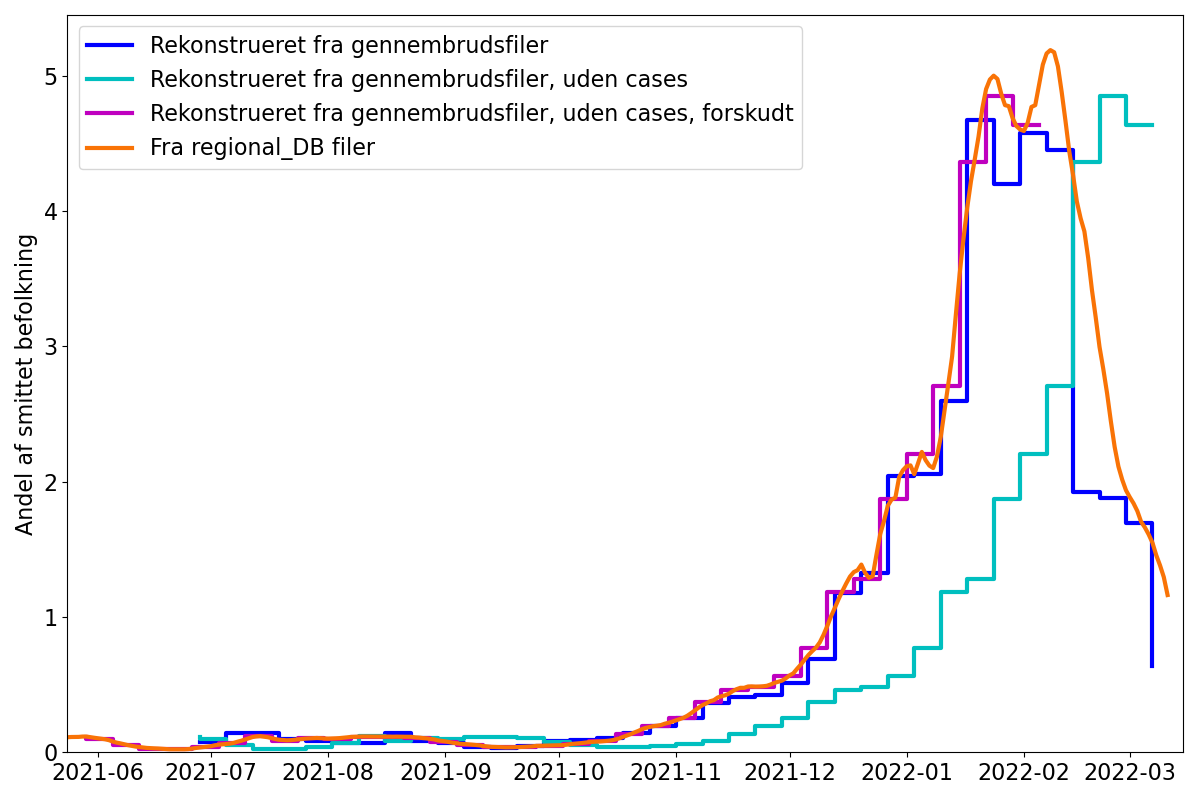

In [ ]:
fig,ax1 = plt.subplots() 


allPos = alleSum[4:] - antalSum[4:] + curPosi + curRepo
# ax1.plot(curDates[5:],100*np.diff(allPos)/alleSum[5:],'b*-',label='Rekonstrueret fra gennembrudsfiler')
# ax1.plot(curDates[5:],100*np.diff(alleSum[4:] - antalSum[4:])/alleSum[5:],'c*-',label='Rekonstrueret fra gennembrudsfiler, uden cases')
ax1.step(curDates[5:],100*np.diff(allPos)/alleSum[5:],color='b',label='Rekonstrueret fra gennembrudsfiler',where='post')
ax1.step(curDates[5:],100*np.diff(alleSum[4:] - antalSum[4:])/alleSum[5:],color='c',label='Rekonstrueret fra gennembrudsfiler, uden cases',where='pre')
ax1.step(curDates[5:]-np.timedelta64(30,'D'),100*np.diff(alleSum[4:] - antalSum[4:])/alleSum[5:],color='m',label='Rekonstrueret fra gennembrudsfiler, uden cases, forskudt',where='pre')


dkPop = popSize.values[-1]
ax1.plot(pf.rnTime(df_inf.index),7*100*pf.rnMean(df_inf.infected)/dkPop,'xkcd:orange',label='Fra regional_DB filer')
# # ax1.plot(df_inf.index+np.timedelta64(30,'D'),100*np.cumsum(df_inf.infected)/dkPop,'r:',label='Cumulative sum\nof all cases,\nshifted 30 days forward')


ax1.set_xlim([curDates[0],np.datetime64('today')])
ax1.legend()

ax1.set_ylabel('Andel af smittet befolkning')

ax1.set_ylim(bottom=0)
fig.tight_layout()

In [ ]:
# alleSum = df_main.iloc

alleSum = df_main.iloc[:,1:4].sum(axis=1)
antalSum = df_main.iloc[:,6:9].sum(axis=1)
antalCase = df_main.iloc[:,11:14].sum(axis=1)
antalCase
curPosi = np.cumsum(antalCase)
curPosi


# fig,ax1 = plt.subplots()

# # ax1.plot(allDTs,alleSum)
# # ax1.plot(allDTs,antalSum)
# ax1.plot(allDTs,(alleSum-antalSum)/alleSum)
# # ax1.plot(allDTs,np.diff((alleSum-antalSum)/alleSum)


# # Antal_personer_alle - Antal_personer + fire ugers cases - fire ugers repositive

0       75968
1      180571
2      324064
3      549906
4      847299
5     1127115
6     1407717
7     1674689
8     1846237
9     1972896
10    2092232
11    2168611
12    2241816
13    2289454
14    2323685
15    2352504
16    2380460
17    2403062
18    2418934
19    2430736
20    2439340
21    2444320
22    2448318
23    2451297
24    2453773
25    2455922
26    2459103
27    2463516
28    2469684
29    2476472
30    2483270
31    2489566
32    2495768
33    2501009
34    2507791
35    2512372
36    2515028
37    2516321
38    2517956
39    2520130
40    2524754
41    2530563
dtype: int64

In [ ]:
unva_case = df_main['antal_cases_Ingen vaccination'].values[::-1]
once_case = df_main['antal_cases_Første vaccination'].values[::-1]
both_case = df_main['antal_cases_Anden vaccination'].values[::-1]
full_case = df_main['antal_cases_Fuld effekt efter primært forløb'].values[::-1]
reva_case = df_main['antal_cases_Fuld effekt efter revaccination'].values[::-1]


unva_case_cumsum = np.cumsum(df_main['antal_cases_Ingen vaccination'].values[::-1])
once_case_cumsum = np.cumsum(df_main['antal_cases_Første vaccination'].values[::-1])
both_case_cumsum = np.cumsum(df_main['antal_cases_Anden vaccination'].values[::-1])
full_case_cumsum = np.cumsum(df_main['antal_cases_Fuld effekt efter primært forløb'].values[::-1])
reva_case_cumsum = np.cumsum(df_main['antal_cases_Fuld effekt efter revaccination'].values[::-1])
# df_main.columns[11:]

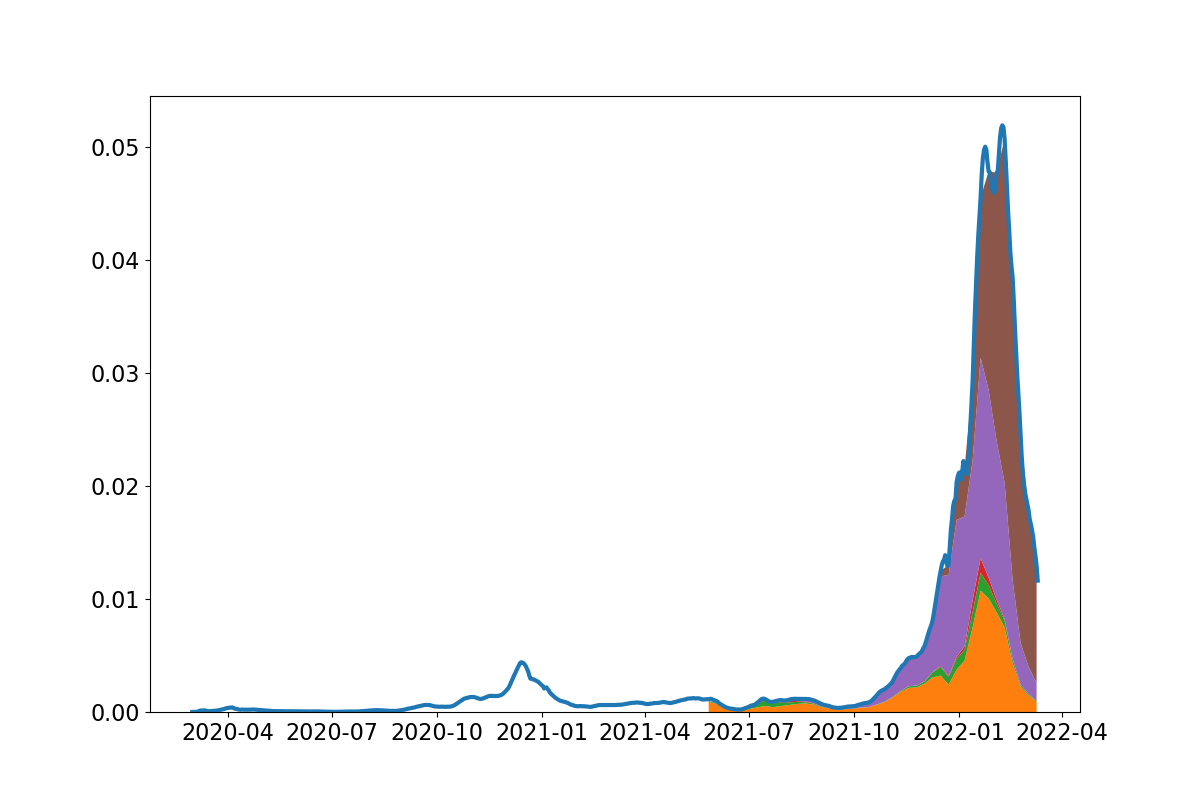

In [ ]:
fig,ax1 = plt.subplots() 
dkPop = popSize.values[-1]
dates = allDTs[::-1]
ax1.plot(pf.rnTime(df_inf.index),7*pf.rnMean(df_inf.infected/dkPop))
# ax1.plot(df_reinf.index,df_reinf.infected/dkPop+df_inf.infected/dkPop)

# ax1.plot(dates,unva_case/dkPop)
ax1.stackplot(dates+np.timedelta64(3,'D'),
                unva_case/dkPop,
                once_case/dkPop,
                (both_case-full_case-reva_case)/dkPop,
                full_case/dkPop,
                reva_case/dkPop
        )

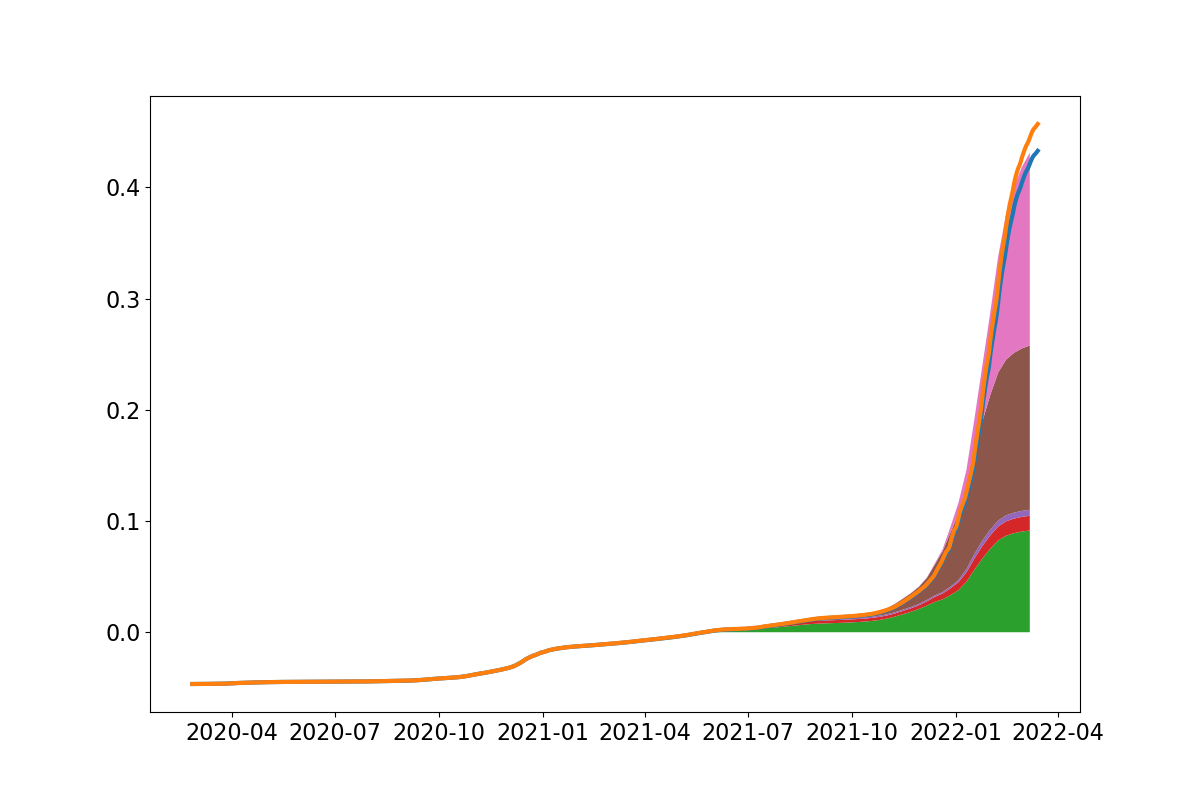

In [ ]:
fig,ax1 = plt.subplots() 
dkPop = popSize.values[-1]
dates = allDTs[::-1]

iniInfIndex = np.where(df_inf.index == dates[0])[0][0]
iniInf = (np.cumsum(df_inf.infected)/dkPop)[iniInfIndex]
ax1.plot(df_inf.index,np.cumsum(df_inf.infected)/dkPop - iniInf)
ax1.plot(df_reinf.index,np.cumsum(df_reinf.infected)/dkPop+np.cumsum(df_inf.infected)/dkPop - iniInf)

# ax1.plot(dates,unva_case/dkPop)
ax1.stackplot(dates,
                unva_case_cumsum/dkPop,
                once_case_cumsum/dkPop,
                (both_case_cumsum-full_case_cumsum-reva_case_cumsum)/dkPop,
                full_case_cumsum/dkPop,
                reva_case_cumsum/dkPop
        )

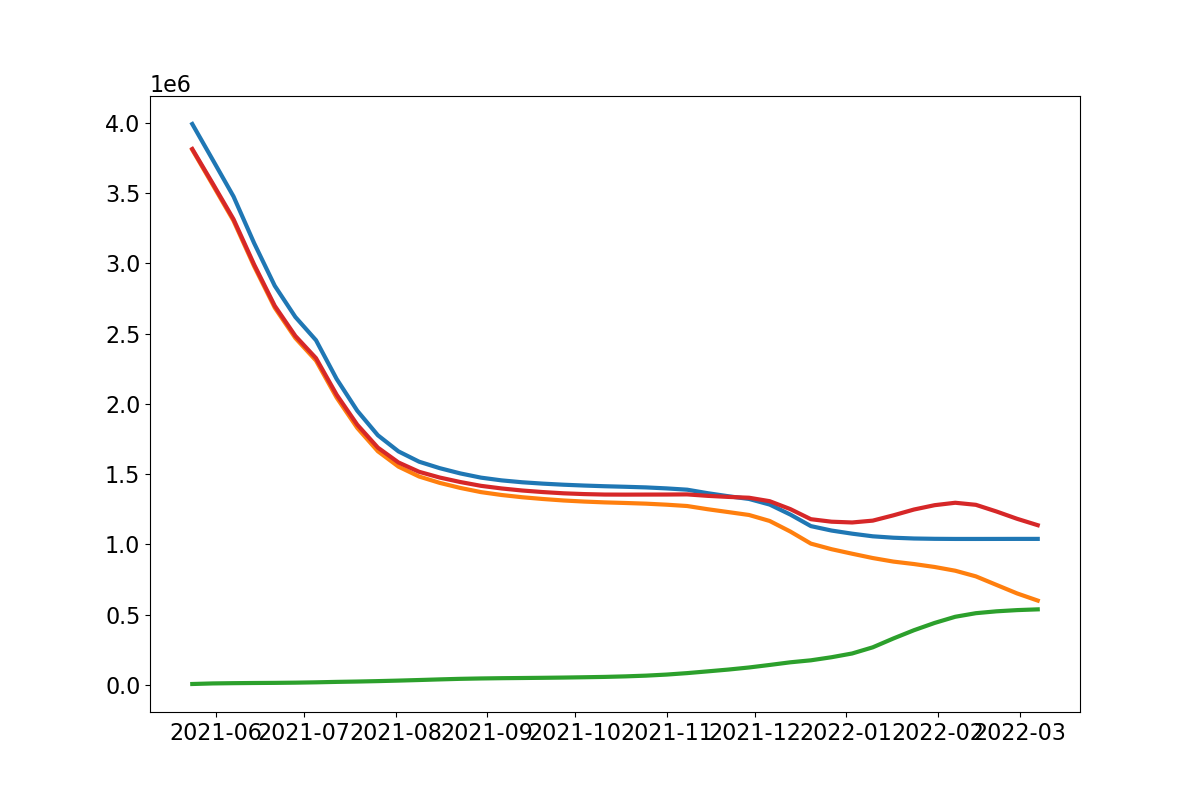

In [ ]:
fig,ax1 = plt.subplots()

curCase = df_main['antal_cases_Ingen vaccination'].values[::-1]
curDates = allDTs[::-1]

ax1.plot(allDTs,df_main['antal_personer_alle_Ingen vaccination'])
ax1.plot(allDTs,df_main['antal_personer_Ingen vaccination'])
# ax1.plot(allDTs,df_main['antal_cases_Ingen vaccination'])
# ax1.plot(allDTs,df_main['antal_cases_Ingen vaccination']+df_main['antal_personer_Ingen vaccination'])
ax1.plot(curDates,np.cumsum(curCase))
ax1.plot(curDates,np.cumsum(curCase)+df_main['antal_personer_Ingen vaccination'].values[::-1])

In [ ]:
curdf = df_main.iloc[::-1,:]
curDates = allDTs[::-1]

thisCase = curdf['antal_personer_alle_Ingen vaccination']-curdf['antal_personer_Ingen vaccination']
thisCase.diff().tail(20)

curdf.iloc[:,[1,6]]
thisCase

41    183073
40    177806
39    173036
38    164910
37    155973
36    149926
35    144860
34    132641
33    122465
32    113865
31    108349
30    105515
29    104758
28    103317
27    103071
26    104086
25    106534
24    109340
23    112199
22    114037
21    114996
20    115377
19    115763
18    115988
17    116256
16    114150
15    112744
14    114129
13    116780
12    120806
11    124634
10    132802
9     142757
8     154750
7     169963
6     181920
5     200507
4     226244
3     266397
2     327418
1     388281
0     439180
dtype: int64

In [ ]:
curdf['antal_cases_Ingen vaccination'].tail(20)

19     5192
18     7597
17    10453
16    12506
15    12789
14    14769
13    17989
12    18868
11    14219
10    21906
9     26701
8     43886
7     62949
6     58920
5     51728
4     43871
3     25507
2     13329
1      8630
0      5333
Name: antal_cases_Ingen vaccination, dtype: int64

In [ ]:
# curdf.columns

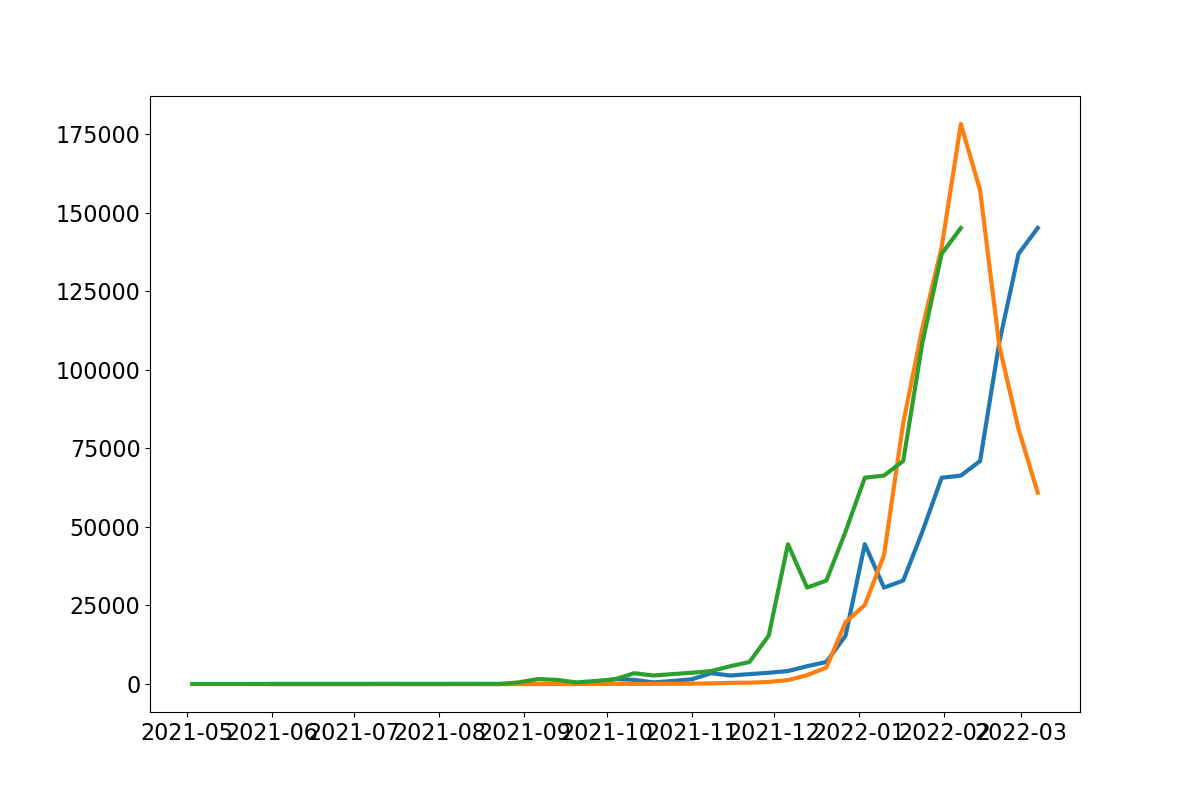

In [ ]:
curdf = df_main.iloc[::-1,:]
curDates = allDTs[::-1]



fig,ax1 = plt.subplots()

thisCase = curdf['antal_personer_alle_Fuld effekt efter revaccination']-curdf['antal_personer_Fuld effekt efter revaccination']
# ax1.plot(curDates,curdf['antal_personer_alle_Fuld effekt efter revaccination']-curdf['antal_personer_Fuld effekt efter revaccination'])
ax1.plot(curDates,thisCase.diff())
# ax1.plot(curDates,curdf['antal_personer_alle_Fuld effekt efter revaccination'])
ax1.plot(curDates,curdf['antal_cases_Fuld effekt efter revaccination'])

ax1.plot(curDates-np.timedelta64(4*7,'D'),thisCase.diff())

In [ ]:
# .loc[:,'antal_personer_alle_Fuld vaccineeffekt'].tail(20)
# df_main.reset_index(drop=True).tail(20)
# antalPrim = df_main


In [ ]:
df_main.loc[:,'antal_personer_alle_Fuld vaccineeffekt'].tail(20)

22          0.0
23          0.0
24          0.0
25          0.0
26          0.0
27          0.0
28          0.0
29          0.0
30          0.0
31    2712311.0
32    2406397.0
33    2156178.0
34    1885891.0
35    1678255.0
36    1525535.0
37    1473979.0
38    1346139.0
39    1257643.0
40    1175731.0
41    1055605.0
Name: antal_personer_alle_Fuld vaccineeffekt, dtype: float64

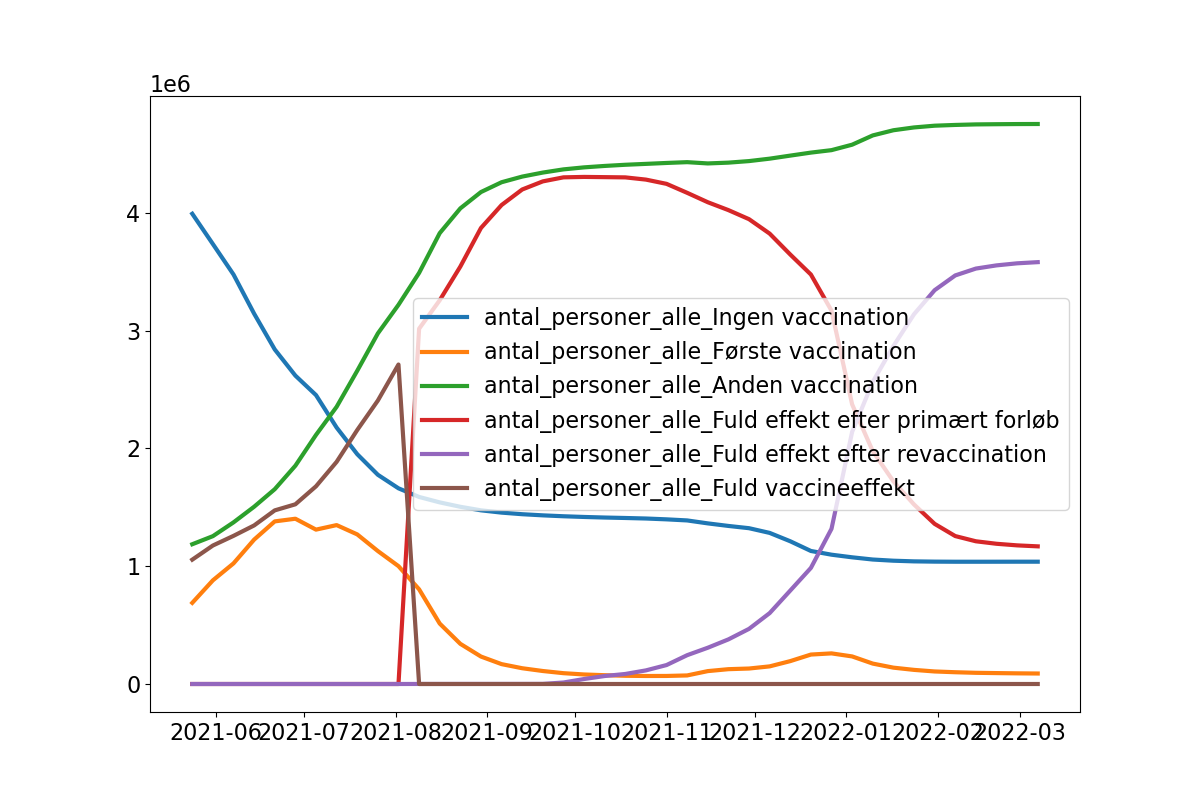

In [ ]:
fig,ax1 = plt.subplots()

curCol = df_main.columns[1]
ax1.plot(allDTs,df_main[curCol],label=curCol)
curCol = df_main.columns[2]
ax1.plot(allDTs,df_main[curCol],label=curCol)
curCol = df_main.columns[3]
ax1.plot(allDTs,df_main[curCol],label=curCol)
curCol = df_main.columns[4]
ax1.plot(allDTs,df_main[curCol],label=curCol) 
curCol = df_main.columns[5]
ax1.plot(allDTs,df_main[curCol],label=curCol) 
curCol = df_main.columns[-4]
ax1.plot(allDTs,df_main[curCol],label=curCol) 

ax1.legend()



unva = df_main.iloc[:,1]
once = df_main.iloc[:,2]
both = df_main.iloc[:,3]
full_pri = df_main.iloc[:,4]
reva = df_main.iloc[:,5]
full_old = df_main.iloc[:,-4]

# Weird error in 2022-03-08 file...

In [ ]:
# allRows[0]

dirPath = path_data + 'SSI_data_2022-03-08'+ '/'
filePath = dirPath+'gennembrudsinfektioner_table1.csv'
if os.path.exists(filePath):
    df1 = pd.read_csv(filePath,delimiter=';')
display(df1)
dirPath = path_data + 'SSI_data_2022-03-01'+ '/'
filePath = dirPath+'gennembrudsinfektioner_table1.csv'
if os.path.exists(filePath):
    df1 = pd.read_csv(filePath,delimiter=';')
display(df1)

Ugenummer  antal_personer_alle_Ingen vaccination  \
0   Uge 09-2022                                1036629   
1   Uge 08-2022                                1036705   
2   Uge 07-2022                                1036531   
3   Uge 06-2022                                1036556   
4   Uge 05-2022                                1037403   
5   Uge 04-2022                                1039657   
6   Uge 03-2022                                1045215   
7   Uge 02-2022                                1055253   
8   Uge 01-2022                                1073998   
9   Uge 52-2021                                1096233   
10  Uge 51-2021                                1127768   
11  Uge 50-2021                                1210162   
12  Uge 49-2021                                1281219   
13  Uge 48-2021                                1321126   
14  Uge 47-2021                                1340308   
15  Uge 46-2021                                1363556   

    antal_personer_alle_Første vaccination  \
0                                    85166   
1                                    87308   
2                                    89672   
3                                    94613   
4                                   101124   
5                                   114557   
6                                   133480   
7                                   167922   
8                                   228796   
9                                   254571   
10                                  244618   
11                                  188922   
12                                  144303   
13                                  126060   
14                                  120551   
15                                  109433   

    antal_personer_alle_Anden vaccination  \
0                                 4758872   
1                                 4757523   
2                                 4755864   
3                                 4751315   
4                                 4744883   
5                                 4730096   
6                                 4706197   
7                                 4662303   
8                                 4583610   
9                                 4537284   
10                                4516422   
11                                4490916   
12                                4464990   
13                                4444374   
14                                4431164   
15                                4419347   

    antal_personer_alle_Fuld effekt efter primært forløb  \
0                                             1182200      
1                                             1195726      
2                                             1216839      
3                                             1261120      
4                                             1364712      
5                                             1529422      
6                                             1725821      
7                                             1981759      
8                                             2378764      
9                                             3174620      
10                                            3481431      
11                                            3651058      
12                                            3828630      
13                                            3951139      
14                                            4028093      
15                                            4089978      

    antal_personer_alle_Fuld effekt efter revaccination  \
0                                             3571335     
1                                             3553756     
2                                             3526732     
3                                             3468491     
4                                             3343127     
5                                             3138937     
6                                   

Ugenummer  antal_personer_alle_Ingen vaccination  \
0   Uge 08-2022                                1035495   
1   Uge 07-2022                                1035666   
2   Uge 06-2022                                1035682   
3   Uge 05-2022                                1036518   
4   Uge 04-2022                                1038767   
5   Uge 03-2022                                1044321   
6   Uge 02-2022                                1054355   
7   Uge 01-2022                                1073098   
8   Uge 52-2021                                1095329   
9   Uge 51-2021                                1126865   
10  Uge 50-2021                                1209254   
11  Uge 49-2021                                1280314   
12  Uge 48-2021                                1320230   
13  Uge 47-2021                                1339414   
14  Uge 46-2021                                1362655   
15  Uge 45-2021                                1388608   

    antal_personer_alle_Første vaccination  \
0                                    87033   
1                                    89321   
2                                    94137   
3                                   100477   
4                                   113505   
5                                   131511   
6                                   164846   
7                                   224208   
8                                   248796   
9                                   236568   
10                                  177449   
11                                  130166   
12                                  109883   
13                                  102429   
14                                   89241   
15                                   72708   

    antal_personer_alle_Anden vaccination  \
0                                 4757629   
1                                 4756030   
2                                 4751591   
3                                 4745306   
4                                 4730914   
5                                 4707918   
6                                 4665130   
7                                 4587940   
8                                 4542788   
9                                 4524190   
10                                4502102   
11                                4478835   
12                                4460243   
13                                4448976   
14                                4439230   
15                                4430197   

    antal_personer_alle_Fuld effekt efter primært forløb  \
0                                             1155303      
1                                             1176656      
2                                             1221542      
3                                             1326582      
4                                             1493446      
5                                             1692560      
6                                             1950614      
7                                             2351263      
8                                             3154388      
9                                             3466609      
10                                            3640355      
11                                            3821647      
12                                            3948111      
13                                            4030571      
14                                            4096919      
15                                            4169794      

    antal_personer_alle_Fuld effekt efter revaccination  \
0                                             3594463     
1                                             3567341     
2                                             3508831     
3                                             3382774     
4                                             3177572     
5                                             2906120     
6                                   

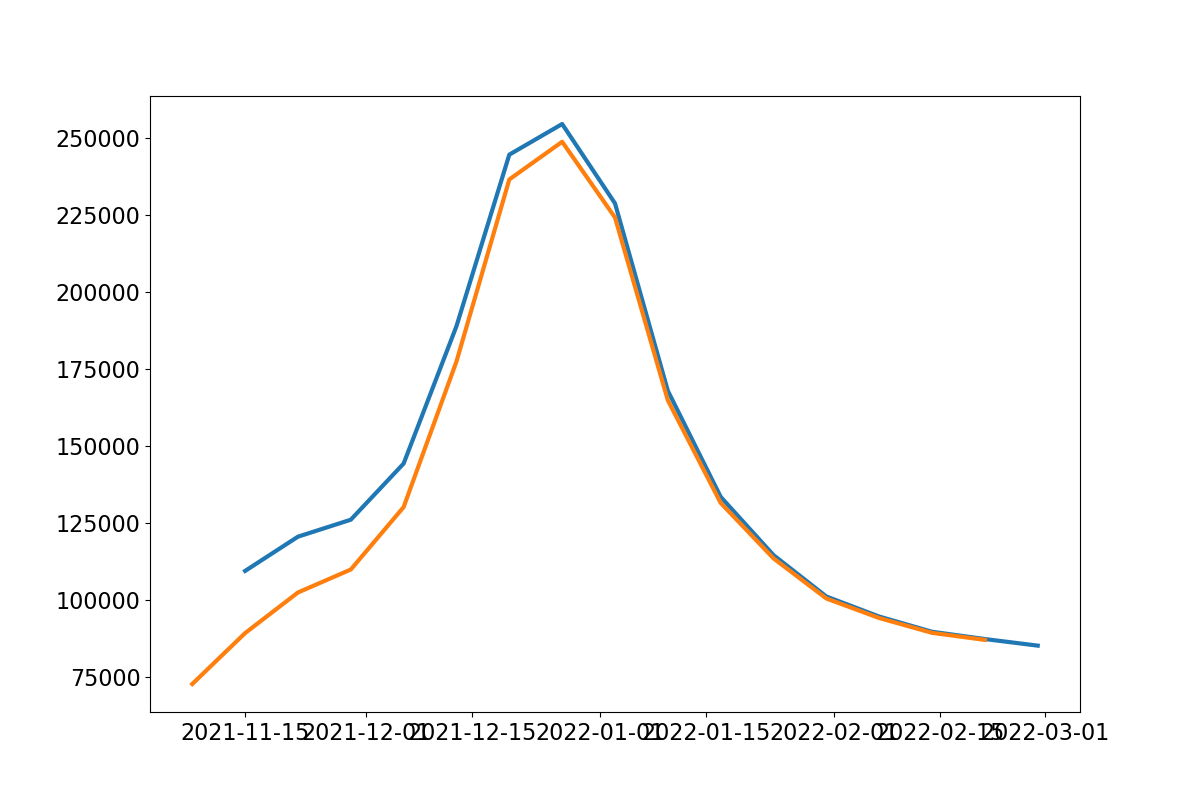

In [ ]:
fig,ax1 = plt.subplots() 



dirPath = path_data + 'SSI_data_2022-03-08'+ '/'
filePath = dirPath+'gennembrudsinfektioner_table1.csv'
if os.path.exists(filePath):
    df1 = pd.read_csv(filePath,delimiter=';')

# display(df1)

weekDTs = [np.datetime64(datetime.datetime.strptime(d[-4:] + '-W'+d[4:6]+'-1', "%Y-W%W-%w")) for d in df1.Ugenummer]

ax1.plot(weekDTs,df1.iloc[:,2])


dirPath = path_data + 'SSI_data_2022-03-01'+ '/'
filePath = dirPath+'gennembrudsinfektioner_table1.csv'
if os.path.exists(filePath):
    df1 = pd.read_csv(filePath,delimiter=';')
# display(df1)


weekDTs = [np.datetime64(datetime.datetime.strptime(d[-4:] + '-W'+d[4:6]+'-1', "%Y-W%W-%w")) for d in df1.Ugenummer]

ax1.plot(weekDTs,df1.iloc[:,2])

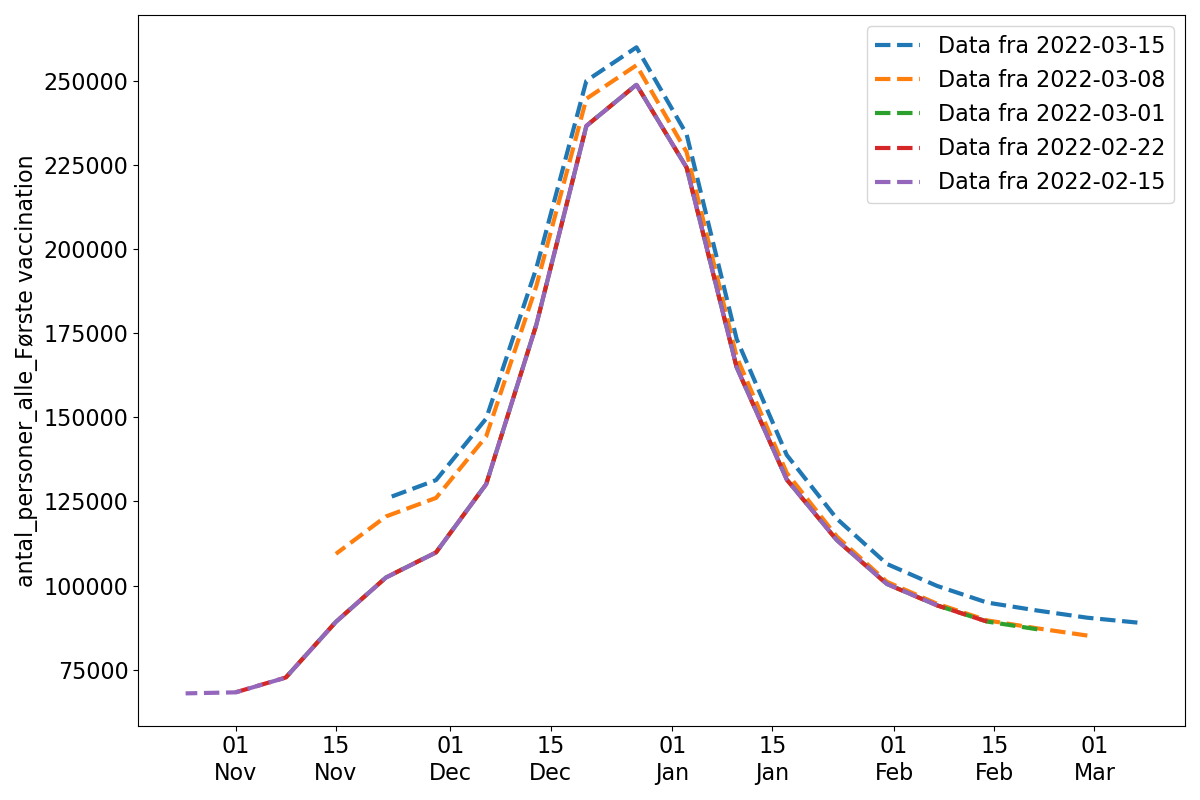

In [ ]:
fig,ax1 = plt.subplots()
curCol = 2
maxWeeksBack = 5
for k in range(0,maxWeeksBack):
    curTue = mostRecentTuesday - np.timedelta64(7*k,'D')
    curTuePath = 'SSI_data_'+str(curTue)

    dirPath = path_data + curTuePath + '/'
    filePath = dirPath+'gennembrudsinfektioner_table1.csv'
    if os.path.exists(filePath):
        df1 = pd.read_csv(filePath,delimiter=';')
    else:
        continue
    
    weekDTs = [np.datetime64(datetime.datetime.strptime(d[-4:] + '-W'+d[4:6]+'-1', "%Y-W%W-%w")) for d in df1.Ugenummer]

    ax1.plot(weekDTs,df1.iloc[:,curCol],'--',label=f'Data fra {curTue}')
ax1.legend()

ax1.set_ylabel(df1.columns[curCol])
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b'))
fig.tight_layout()
